# BI-PRS - Semestral work 3

In [1]:
# Dataset selection according to the represant's data
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

In [28]:
# TODO: lexicographical order

# Neccessary imports
library(eurostat)
library(car)
library(cowplot)
library(tseries)
library(lmtest)
library(countrycode)
library(stringr)
library(ggplot2)
library(gridExtra)
library(psych)
library(corrplot)

## Abstract

The project examines the [**Gross Domestic Product (GDP)**](https://www.investopedia.com/terms/g/gdp.asp) of **European countries** in **2013**. The study investigates [**nominal GDP per capita**](https://www.investopedia.com/terms/n/nominalgdp.asp) in particular.

**Table of contents:**
- Dataset preparation
- GDP elucidation
- Regressors selection
- Dependencies visualization
- Statistical tests
- Linear model
- Outliers
- Multicollinearity
- Model Premises Tests
- Final Model

## Data preparation

In [3]:
# Load the dataset
data <- get_eurostat(id='nama_10_pc')
head(data, 5)

Table nama_10_pc cached at /tmp/RtmpdkD5aw/eurostat/6260eb1c490743d8a38d5e75029035ff.rds



freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580


Transform the dataset, leaving only **Gross Domestic Product per capita** in euros in **2013** for individual European countries.

In [4]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'    # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &     # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',       # European Union - 28 countries (2013-2020)
                   'EU15',       # European Union - 15 countries (1995-2004)
                   'EA',         # Euro area
                   'EA20',       # Euro area – 20 countries (from 2023)
                   'EA19',       # Euro area - 19 countries  (2015-2022)
                   'EA12'        # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)
head(data, 3)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210


In [5]:
any(is.na(data$GDPpc)) # Check for NA values

[1] FALSE

## GDP elucidation

Analyze the `GDPpc` using statistical metrics and visualizations.

In [6]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28576.22,26468.78,1.873799,3.839408,4351.441,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an *“eastern”* tail in the distribution. Let's check it out on the histogram.

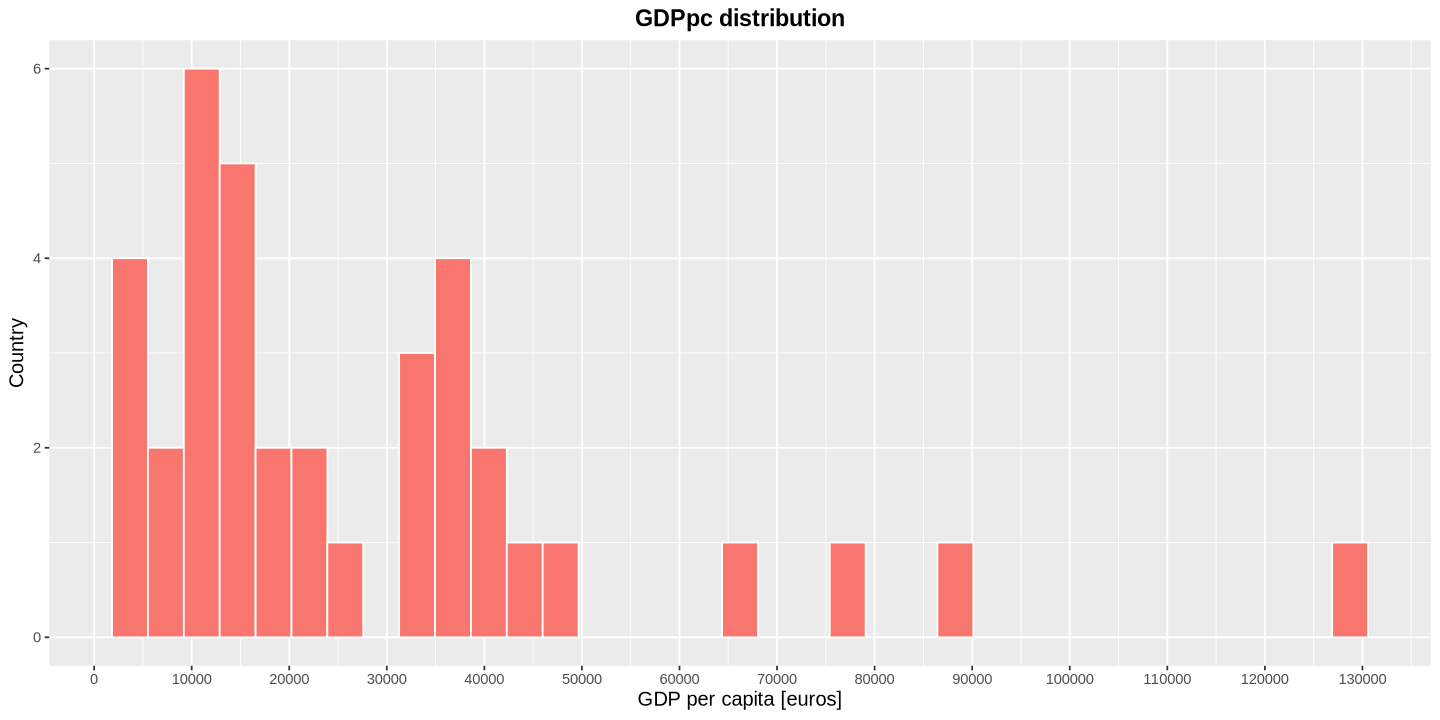

In [7]:
options(repr.plot.width=12, repr.plot.height=6)                        # figure settings 

ggplot(data, aes(x=GDPpc)) +                                           
  geom_histogram(bins=35, fill='#f8766d', col='white') +               # hist
  labs(title='GDPpc distribution',                                     # labels        
       x='GDP per capita [euros]',
       y='Country') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=12)) +             # set x axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

As expected, the distribution has a tail. Several countries have a much higher `GDPpc` than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution.

## Regressors selection

[Many factors](https://www.investopedia.com/articles/investing/051415/how-calculate-gdp-country.asp) can affect the GDP per capita and a country's economy. Below we offer three variants of a continuous variable and one binary. [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report) will be a data source for regressors. [(link)](https://hdr.undp.org/data-center/documentation-and-downloads)

### Continuous regressors

In [8]:
# Load the dataset
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [9]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
head(extra_data, 5)

,iso3,country,hdicode,region,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Afghanistan,Low,SA,182,0.284,0.292,0.299,0.307,0.300,⋯,31.5412085,32.7162100,33.7534990,34.6362075,35.6434175,36.6867840,37.769498,38.972231,40.099462,41.128771
2,ALB,Albania,High,ECA,74,0.649,0.632,0.616,0.618,0.623,⋯,2.8870140,2.8841020,2.8824805,2.8810630,2.8793550,2.8770130,2.873883,2.866849,2.854710,2.842321
3,DZA,Algeria,High,AS,93,0.593,0.596,0.601,0.602,0.603,⋯,38.0006265,38.7601675,39.5431545,40.3393285,41.1365460,41.9270070,42.705368,43.451666,44.177968,44.903225
4,AND,Andorra,Very High,,35,NA,NA,NA,NA,NA,⋯,0.0713665,0.0716215,0.0717455,0.0725405,0.0738365,0.0750135,0.076343,0.077700,0.079034,0.079824
5,AGO,Angola,Medium,SSA,150,NA,NA,NA,NA,NA,⋯,26.1470020,27.1283365,28.1277210,29.1547455,30.2086280,31.2735330,32.353588,33.428486,34.503774,35.588987


In [10]:
# Check if the additional dataset has all countries required
all(data$country %in% extra_data$country)

[1] TRUE

Only some features are needed, which are:
- `LE`: Life Expectancy at Birth (years)
- `MYS`: Mean Years of Schooling (years)
- `EYS`: Expected Years of Schooling (years)
- `GNIpc`: Gross National Income Per Capita (2017 PPP$)
*all for 2013

In [11]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [12]:
any(is.na(extra_data)) # Check for NA values

[1] FALSE

In [13]:
data <- merge(data, extra_data, by='country') # Merge the datasets

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [14]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]
head(data, 5)

,country,GDPpc,LE,EI,NFIApc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,3320,78.123,0.7781896,5376.903
2,Austria,38210,81.078,0.8383914,1791.626
3,Belgium,35210,80.468,0.9221770,1962.076
4,Bulgaria,5790,74.849,0.7824033,8144.946
5,Croatia,10480,77.843,0.8044435,7332.921


#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [**link**](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [15]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

head(data, 5)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE


## Data Visualization

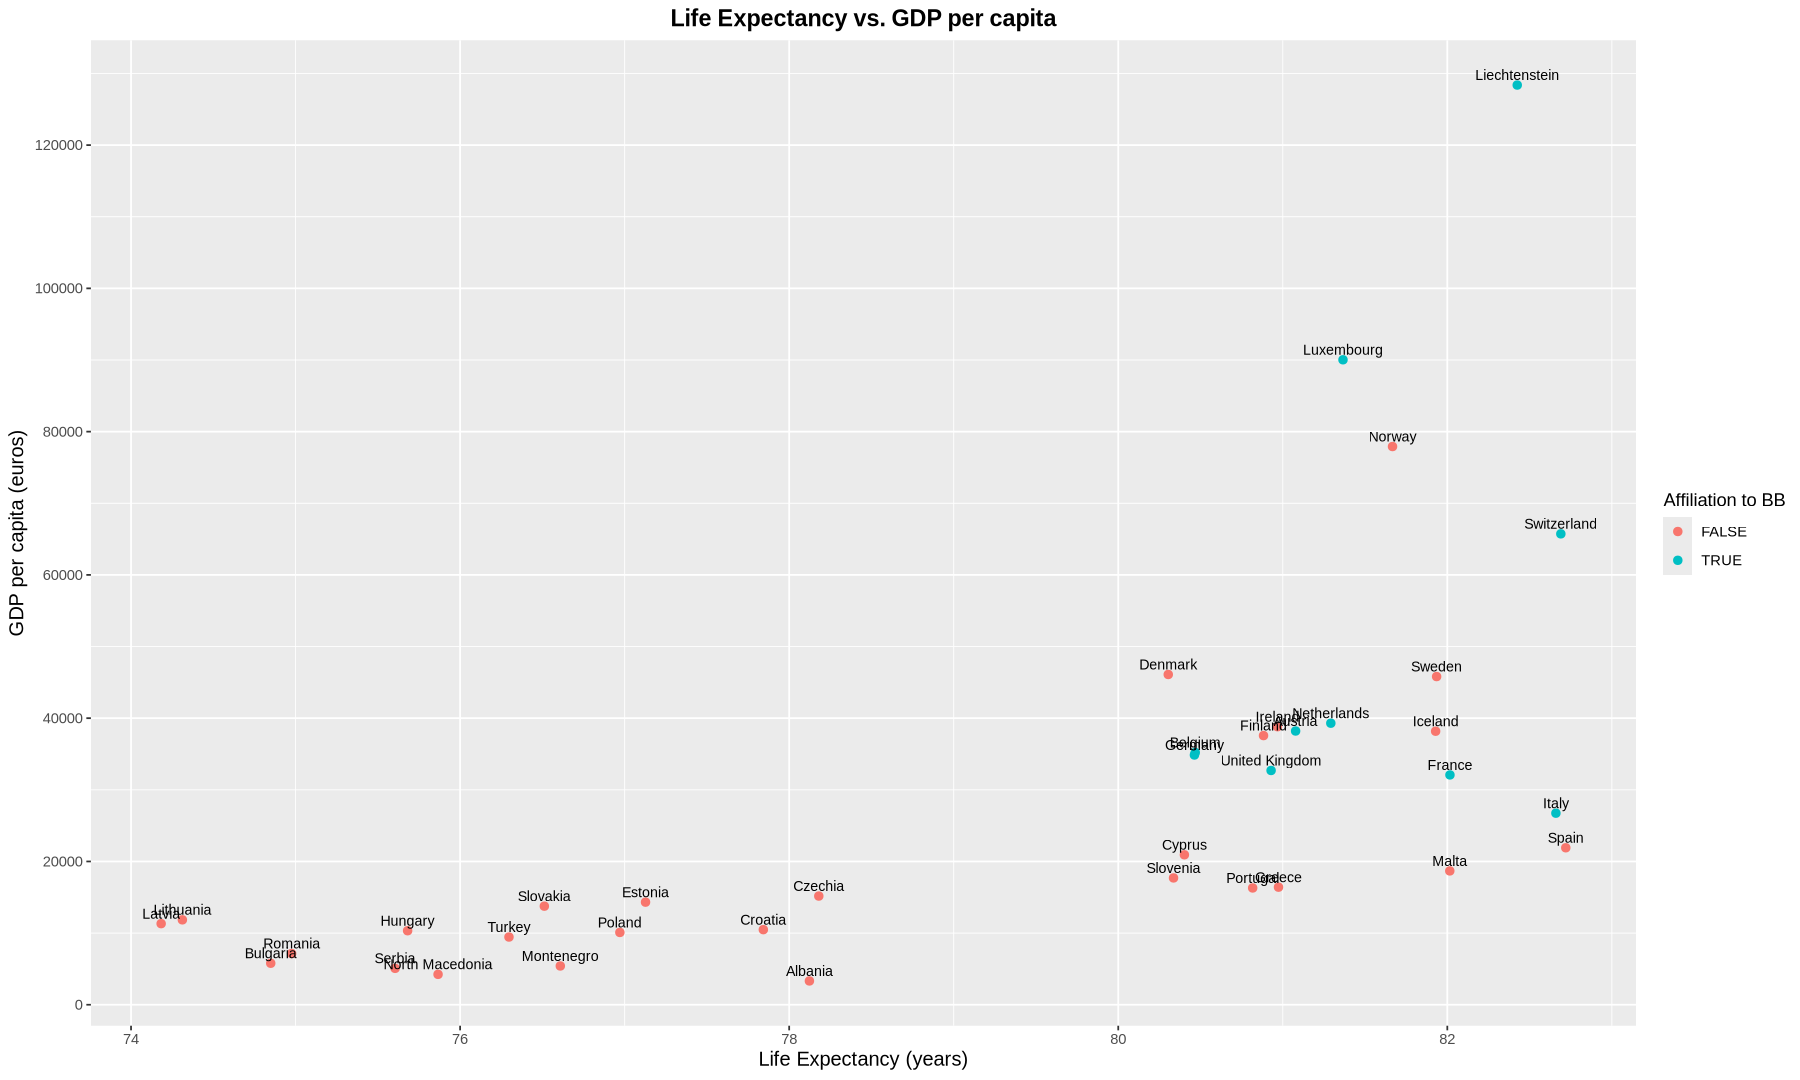

In [16]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +                              
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +       
  labs(title='Life Expectancy vs. GDP per capita',                     # labels
       x='Life Expectancy (years)',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +             # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- The plot helps visualize economic disparities and their potential impact on life expectancy across different countries.
- There is a visible trend where countries with higher GDP per capita and affiliation to BB generally have higher life expectancies.

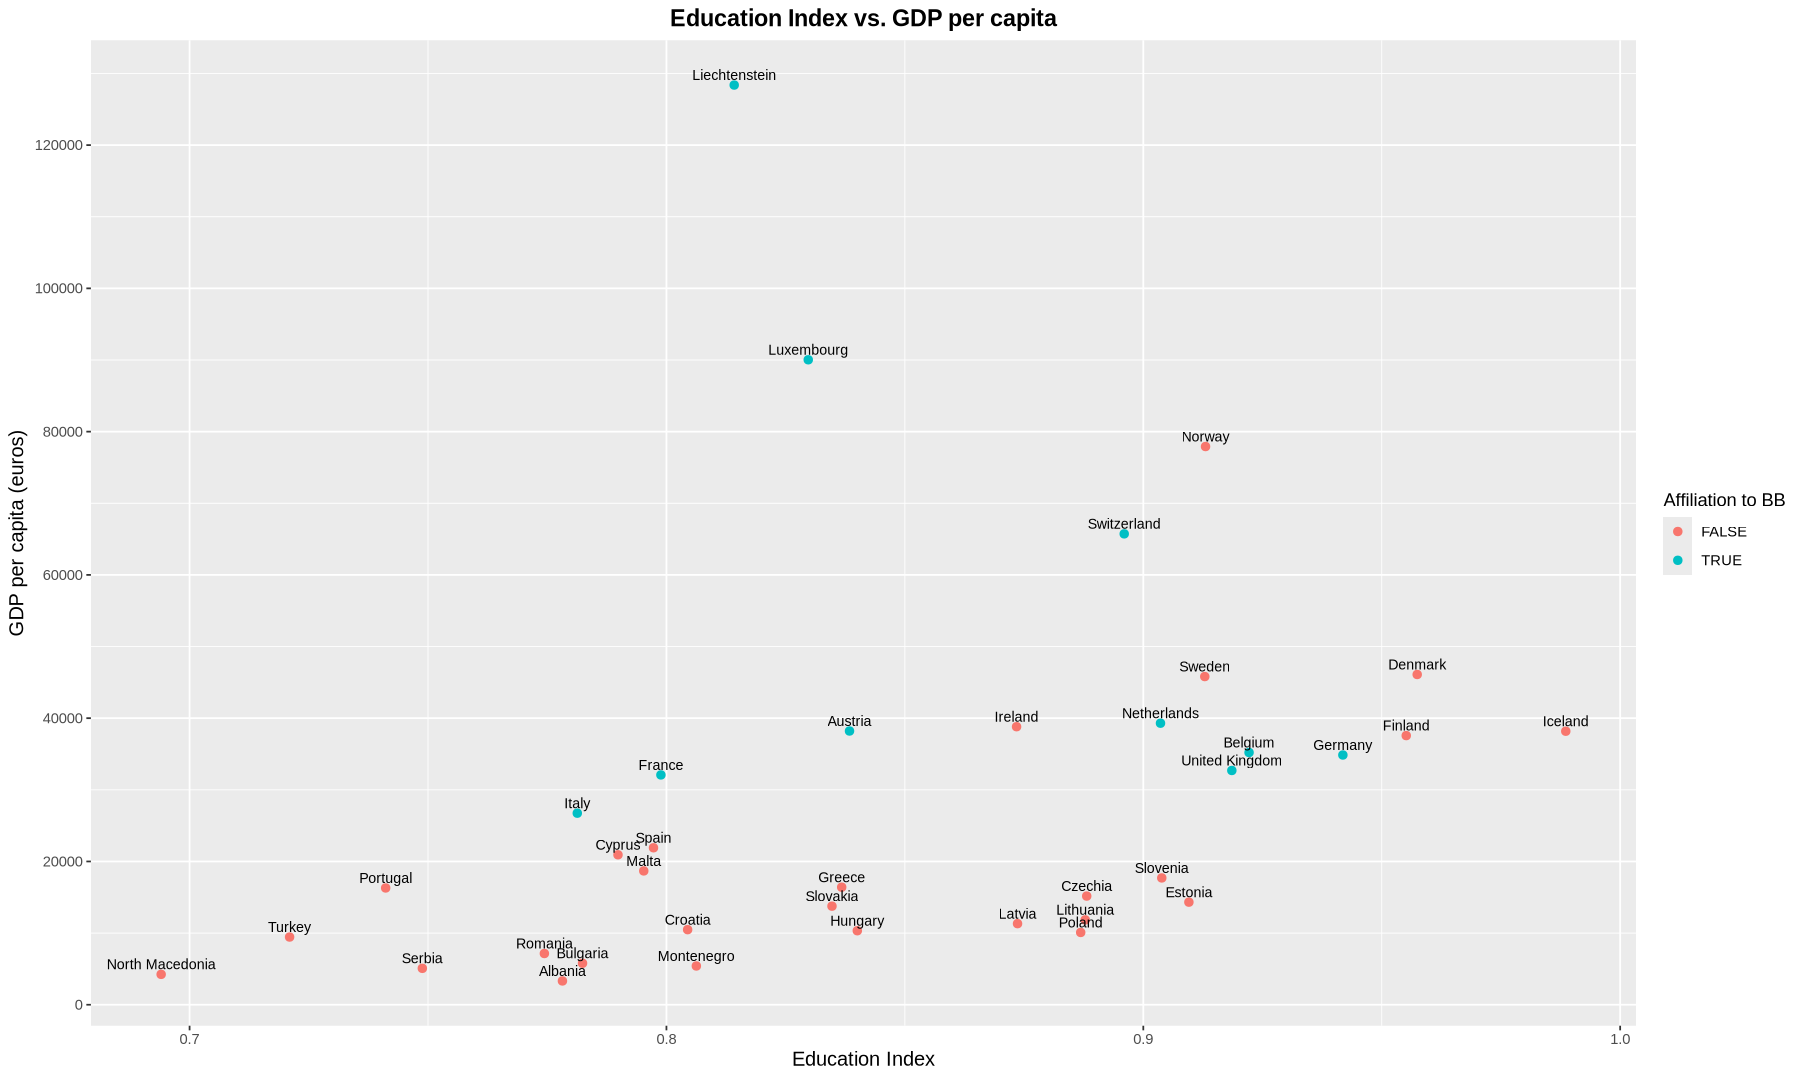

In [17]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +  
  labs(title='Education Index vs. GDP per capita',                     # labels
       x='Education Index',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +            # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- There is a general trend showing that countries with higher Education Index scores tend to have higher GDP per capita.
- Outliers like Liechtenstein and Luxembourg have exceptionally high GDP per capita compared to their Education Index.
- Countries with lower Education Index scores (around 0.7 to 0.8) generally have lower GDP per capita, such as North Macedonia, Turkey, and Serbia.

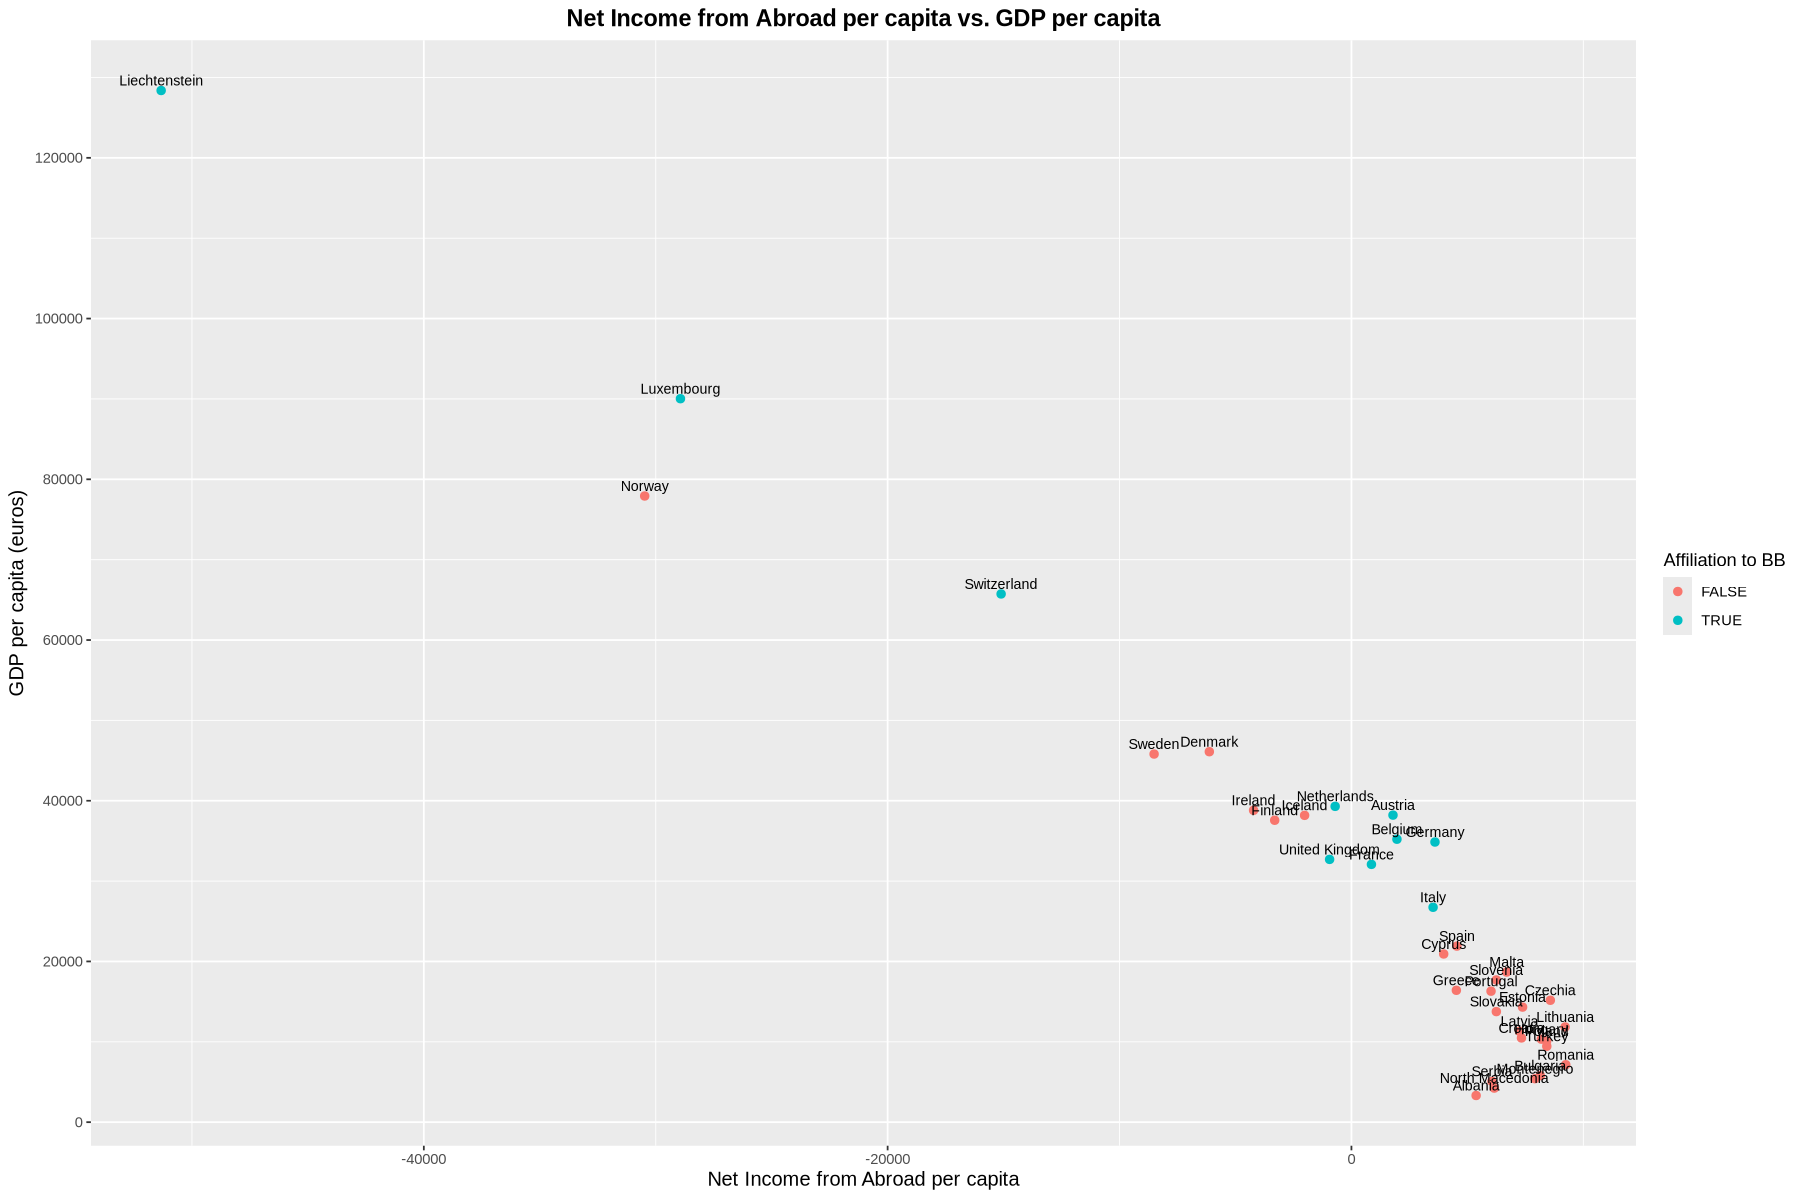

In [18]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  geom_text(aes(label=country), size=3, vjust=-0.5, hjust=0.5) +  
  labs(title='Net Income from Abroad per capita vs. GDP per capita',   # labels
       x='Net Income from Abroad per capita',
       y='GDP per capita (euros)',
       color='Affiliation to BB') + 
  scale_y_continuous(breaks=scales::pretty_breaks(n=5)) +            # set y axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- Liechtenstein, Luxembourg, and Norway are notable outliers with high GDP per capita despite negative or zero Net Income from Abroad per capita.
- Most countries cluster around lower GDP per capita values and with low positive Net Income from Abroad per capita.
- The majority of countries have positive Net Income from Abroad per capita, but there are a lot of countries with negative values, suggesting that they spend more abroad than they receive.

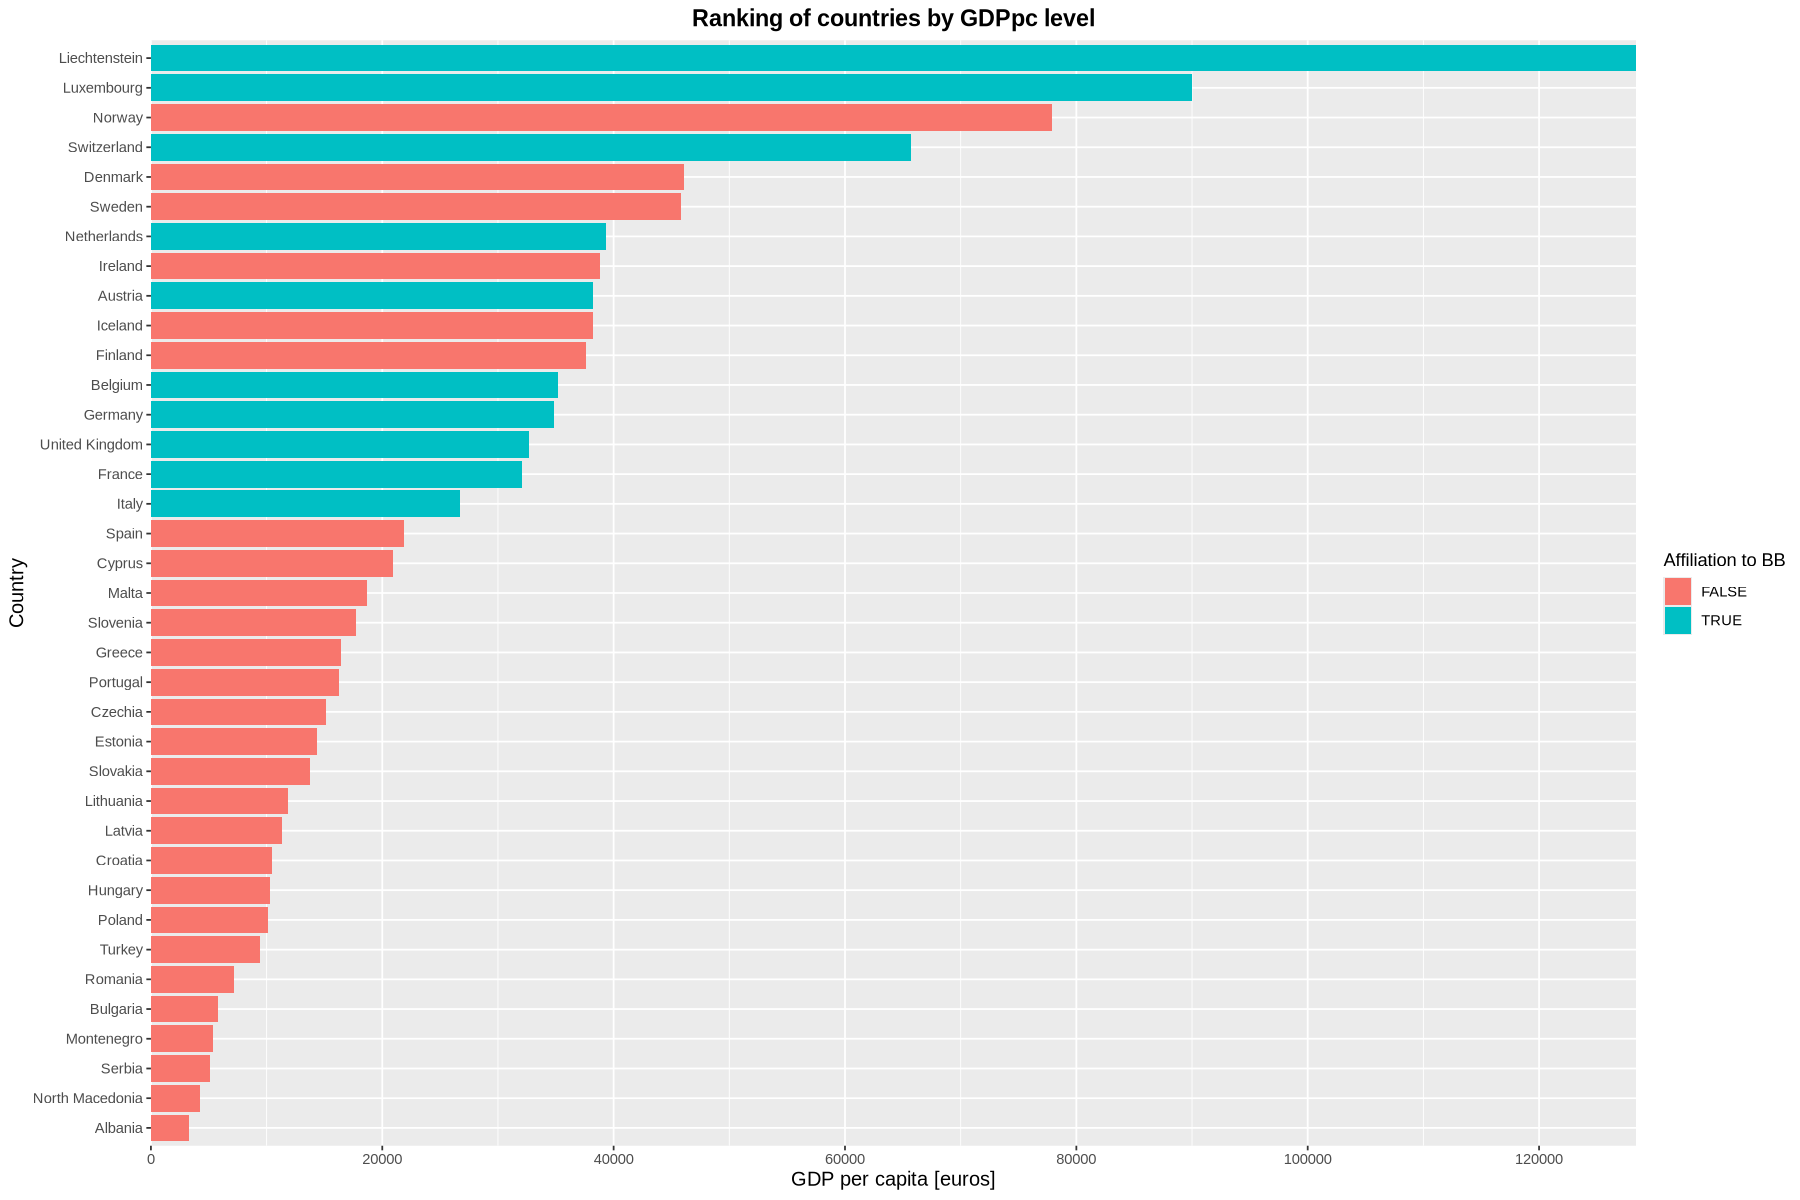

In [19]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country',
       fill='Affiliation to BB') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0)) +
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

- Top Performers: Liechtenstein, Luxembourg, and Norway are at the top of the list, having the highest GDP per capita.
- Mid-range Performers: Countries like Germany, the United Kingdom, and France are in the middle range, with moderate GDP per capita levels.
- Lower Performers: Countries like Albania, North Macedonia, and Serbia are at the bottom, with the lowest GDP per capita.
- Countries that are listed in BB are placed only in best performing half of the countries presented.

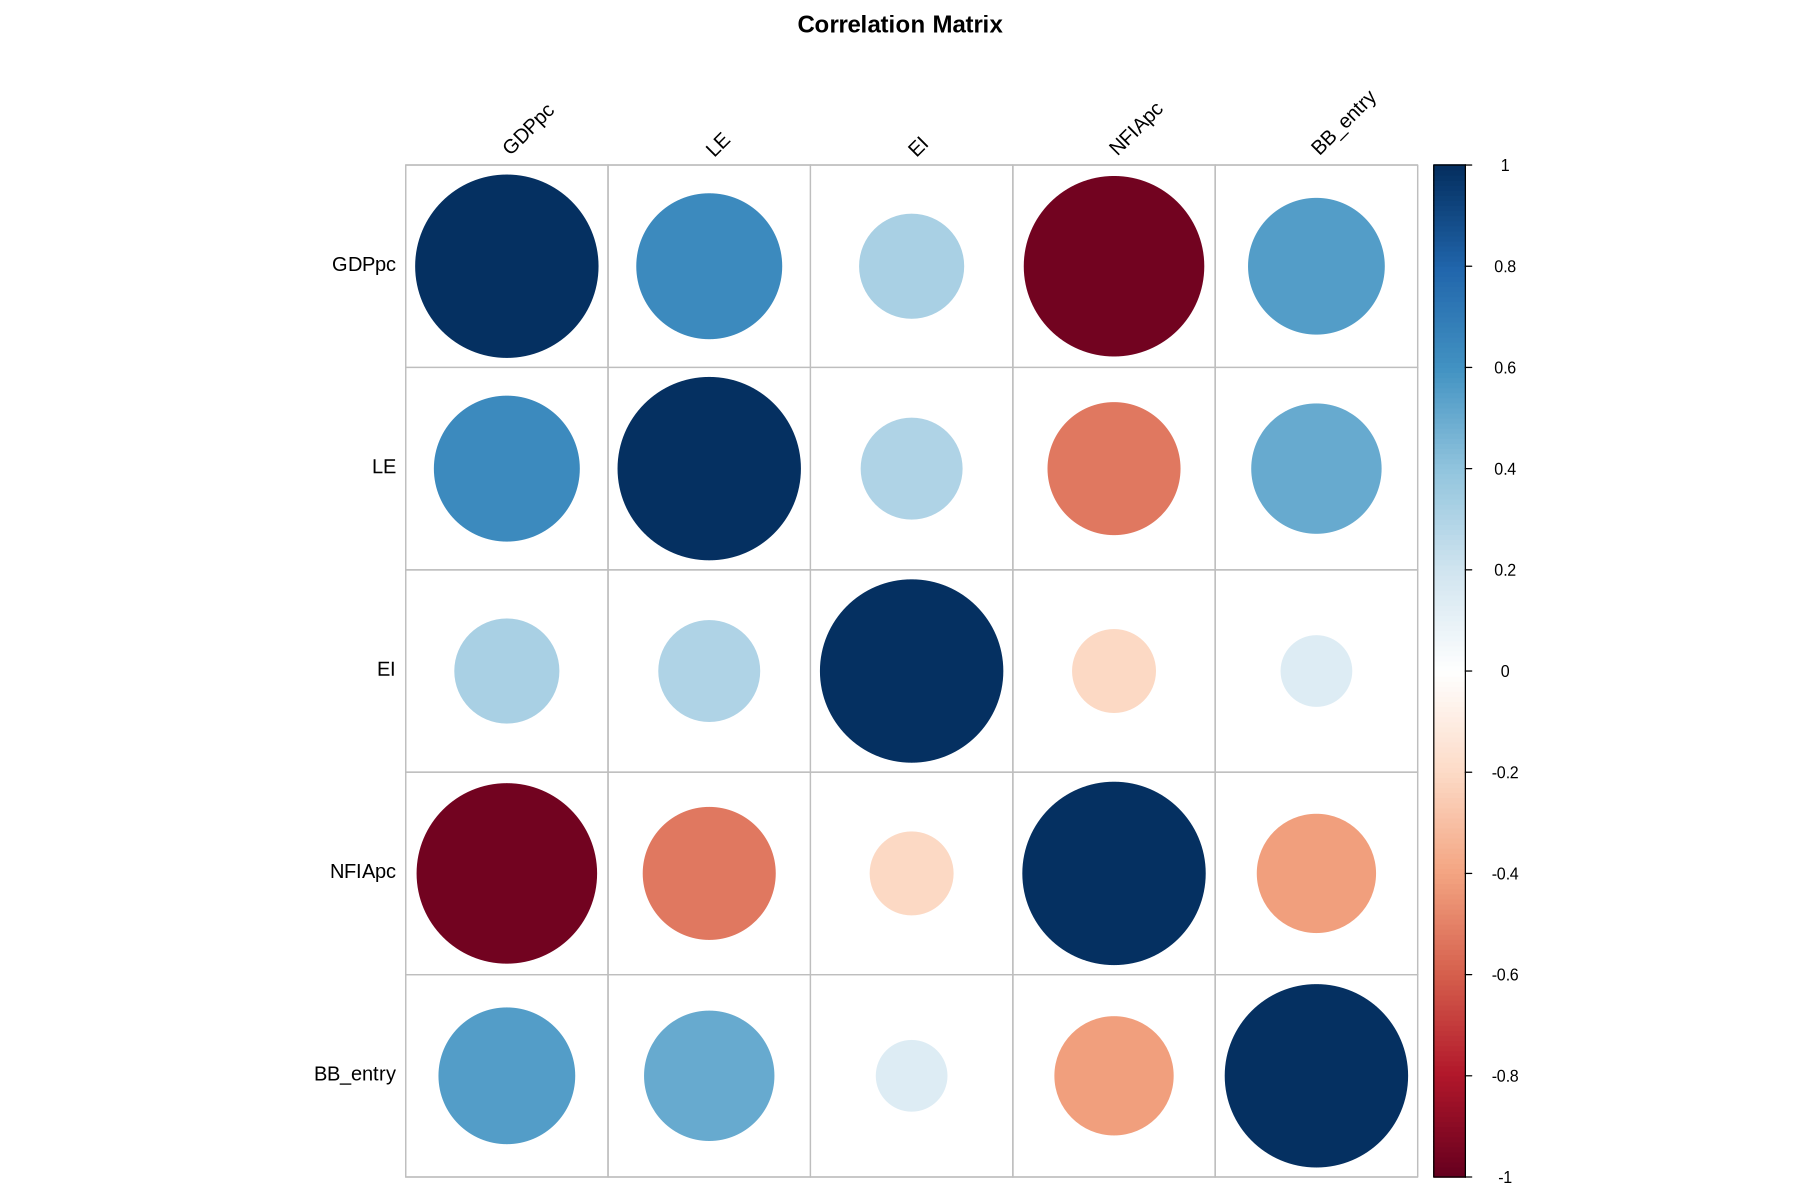

In [20]:
corrplot(cor(data[, -1]), method="circle", 
         tl.col="black", tl.srt=45, 
         title="Correlation Matrix", mar=c(0,0,2,0))

- GDPpc and LE: There is a strong positive correlation between GDP per capita and Life Expectancy, suggesting that higher economic output per person is associated with longer life expectancy.
- NFIapc and GDPpc: There is a strong negative correlation between Net Foreign Income per capita and GDP per capita, suggesting that countries with high GDP per capita tend to have lower net foreign income per capita.
- NFIapc and LE: Similarly, there is a negative correlation between Net Foreign Income per capita and Life Expectancy.

## Tests

In [21]:
# ??????

## Linear model

Simple linear model with all regressors:

In [22]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-10322  -1414      4   2483   5292 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.239e+04  2.214e+04  -3.270 0.002578 ** 
LE            8.415e+02  2.869e+02   2.934 0.006151 ** 
EI            3.814e+04  8.974e+03   4.250 0.000173 ***
NFIApc       -1.747e+00  5.781e-02 -30.215  < 2e-16 ***
BB_entryTRUE  8.231e+03  1.613e+03   5.103 1.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16


**Results interpretation:**
- Intercept: -72210 : predicted value of GDPpc when all independent variables are zero.
- LE (Life Expectancy): 839.6 : for each additional year of life expectancy, GDPpc is expected to increase by 839.6 units
- EI (Education Index): 38100 : for each unit increase in the education index, GDPpc is expected to increase by 38100 units
- NFIApc (Net Foreign Income per capita): -1.746 : for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.746 units
- BB_entryTRUE: 8246 : f BB_entry is TRUE, GDPpc is expected to increase by 8246 units compared to when BB_entry is FALSE.

- Adjusted R-squared: 0.9807 : 98.07% of the variability is explained, suggesting a very good model fit.

**Conclusion:**
The regression analysis shows that all independent variables (LE, EI, NFIapc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net foreign income per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. The model is a very good fit for the data.

## Outliers

We will start with boxplots and violinplots to detect outliers in data distributions of numerical features:

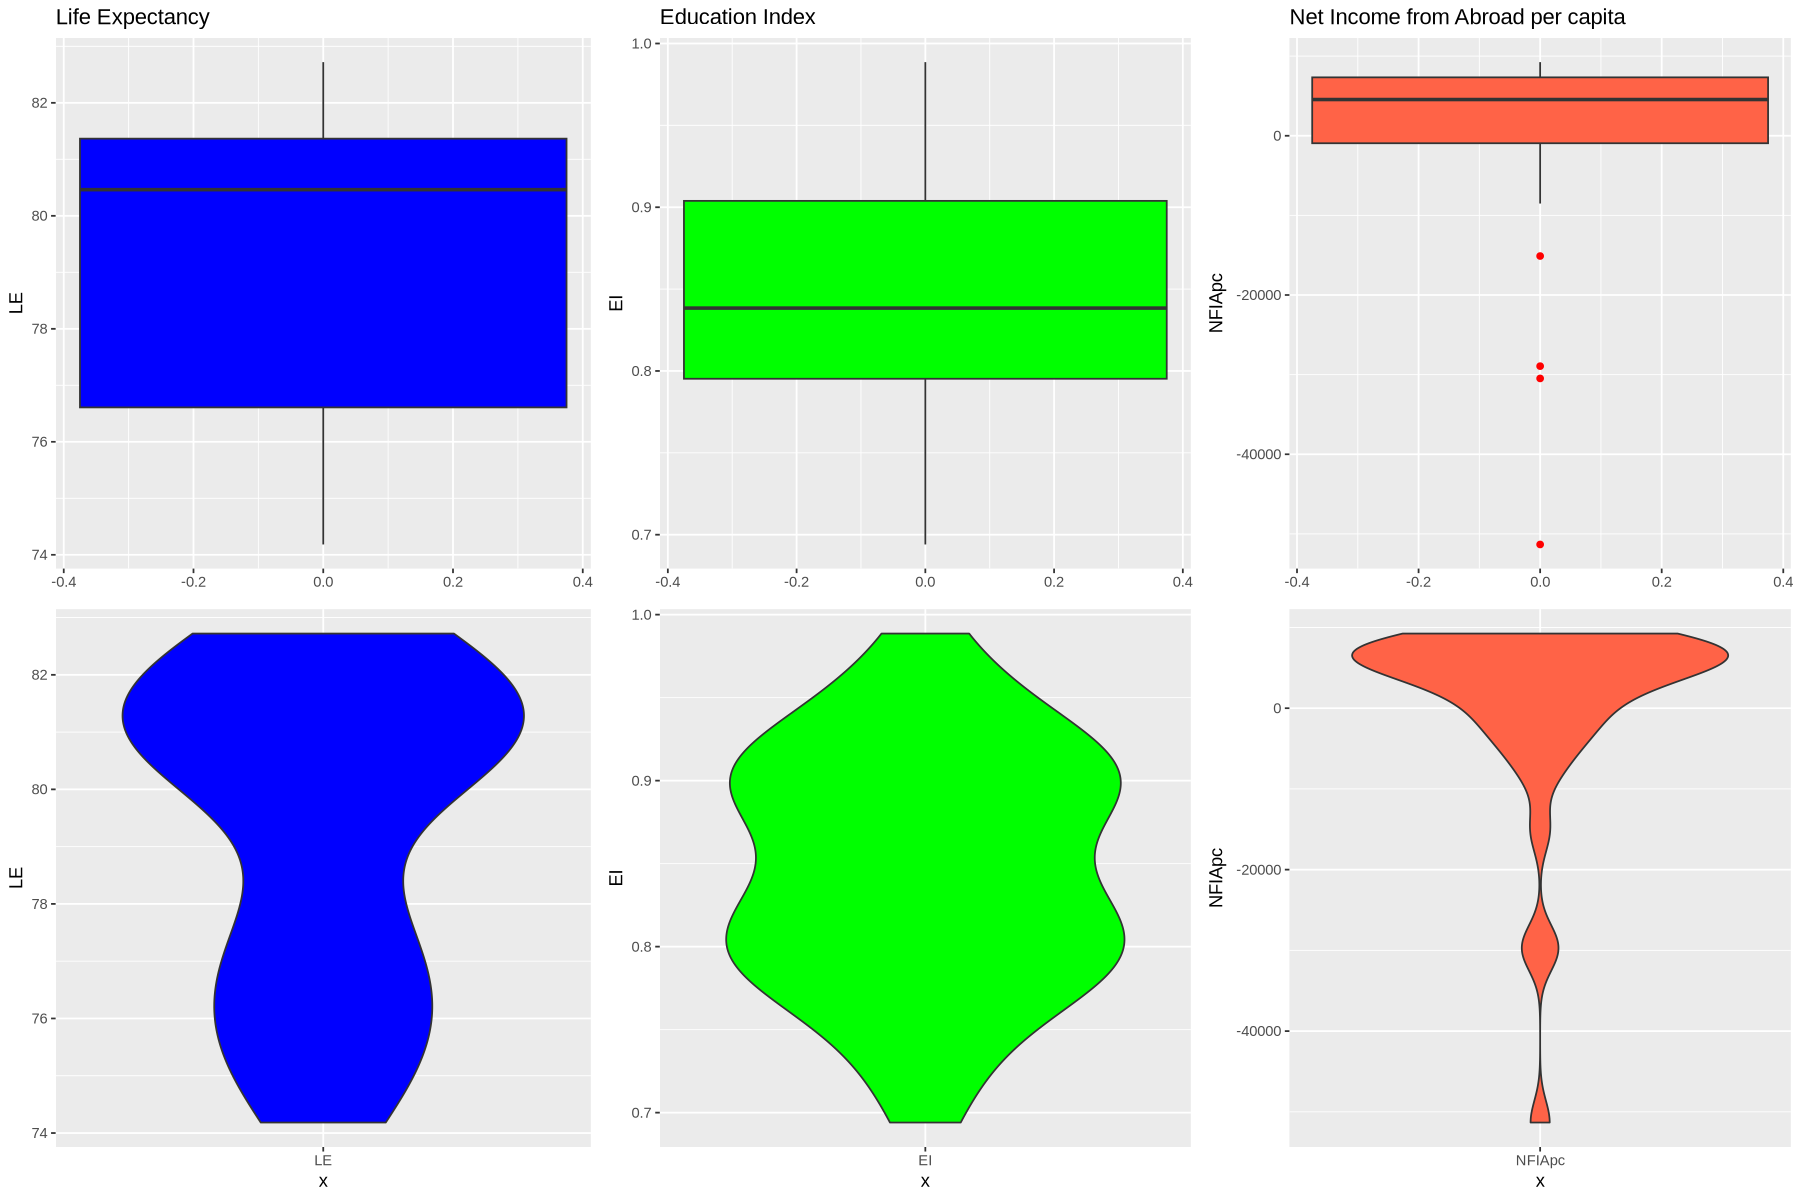

In [29]:

options(repr.plot.width = 15, repr.plot.height=10)

# Create individual ggplots
boxplot_LE <- ggplot(data, aes(y=LE)) + 
    geom_boxplot(fill="blue", outlier.color="red") +
    ggtitle("Life Expectancy")
violin_LE <- ggplot(data, aes(x="LE", y=LE))+
    geom_violin(fill= "blue")

boxplot_EI <- ggplot(data, aes(y=EI)) + 
    geom_boxplot(fill="green", outlier.color="red") +
    ggtitle("Education Index")
violin_EI <- ggplot(data, aes(x="EI", y=EI)) +
    geom_violin(fill= "green")

boxplot_NFIApc <- ggplot(data, aes(y=NFIApc)) + 
    geom_boxplot(fill="tomato", outlier.color="red") +
    ggtitle("Net Income from Abroad per capita")
violin_NFIApc <- ggplot(data, aes(x="NFIApc", y=NFIApc)) +
    geom_violin(fill= "tomato")

# Arrange the plots in a single row
plot_grid(boxplot_LE, boxplot_EI, boxplot_NFIApc,
             violin_LE, violin_EI, violin_NFIApc,
             nrow = 2, ncol = 3)
             

We can see that the Net Income from Abroad per capita has some outliers in its data. Of course, we should be primarly concerned how those regressors affect the target variable.

Now, let's see how the model with all the regressors affects the target variable:

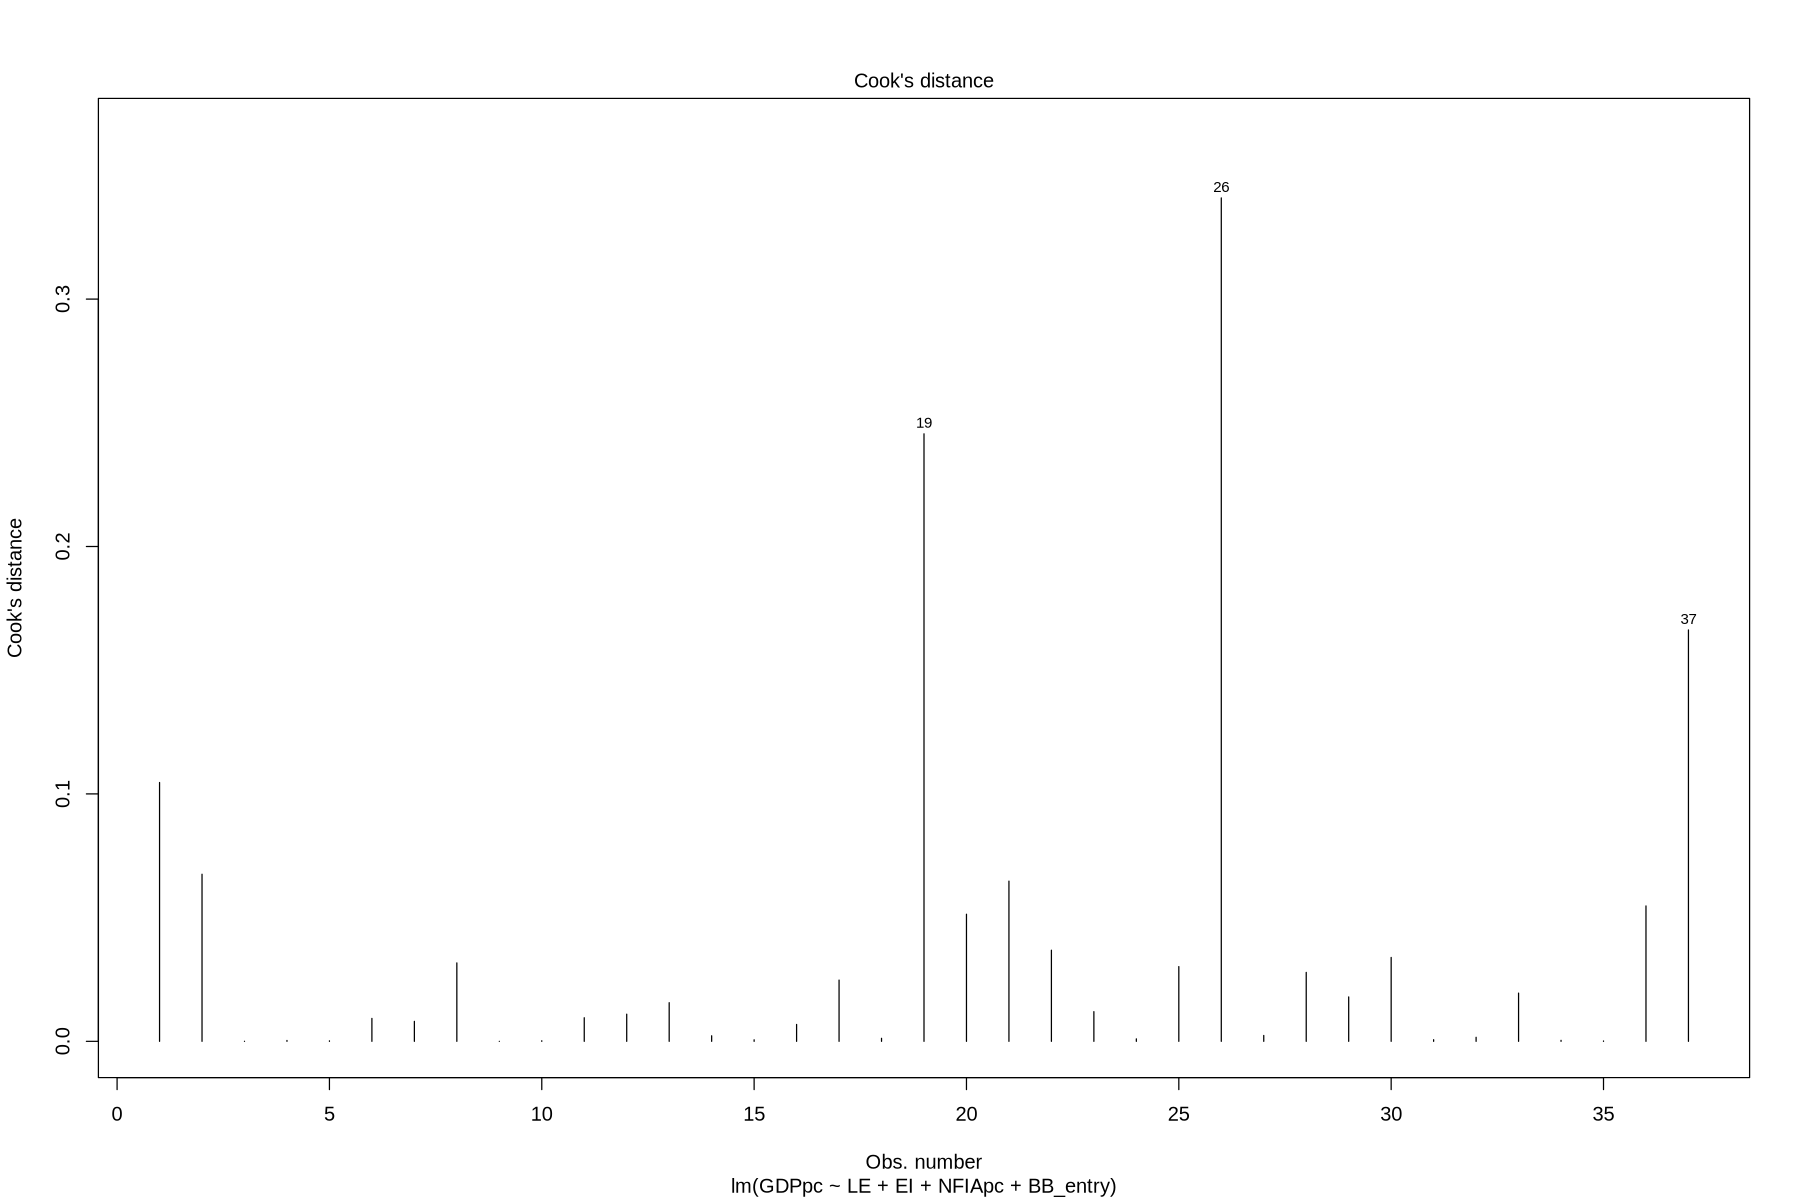

In [24]:
plot(model, which=4)

We see, that datapoints 19, 26, 37 may affect the model prediction, because as cooks distance suggest, by removing those points the difference in prediction changes by the distance values.



In [25]:
data[c(19, 26, 37),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
19,Liechtenstein,128380,82.425,0.8142102,-51327.3400,TRUE
26,Norway,77920,81.667,0.9130506,-30476.4766,FALSE
37,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


Looking back at scatter plots between regressor and target variable, we can see that Lichtenstein is a strong outlier na Eductaion Index vs GDPpc plot and Life Expectancy vs GDPpc plot. Let's see how we can try to fix this issue, probably using some function.

In [31]:
fit_LE <- lm(GDPpc ~ LE, data = data)
summary(fit_LE)


Call:
lm(formula = GDPpc ~ LE, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-27402  -9408  -1249   3485  80847 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -449755      99444  -4.523 6.72e-05 ***
LE              6033       1254   4.813 2.82e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20820 on 35 degrees of freedom
Multiple R-squared:  0.3983,	Adjusted R-squared:  0.3811 
F-statistic: 23.16 on 1 and 35 DF,  p-value: 2.82e-05


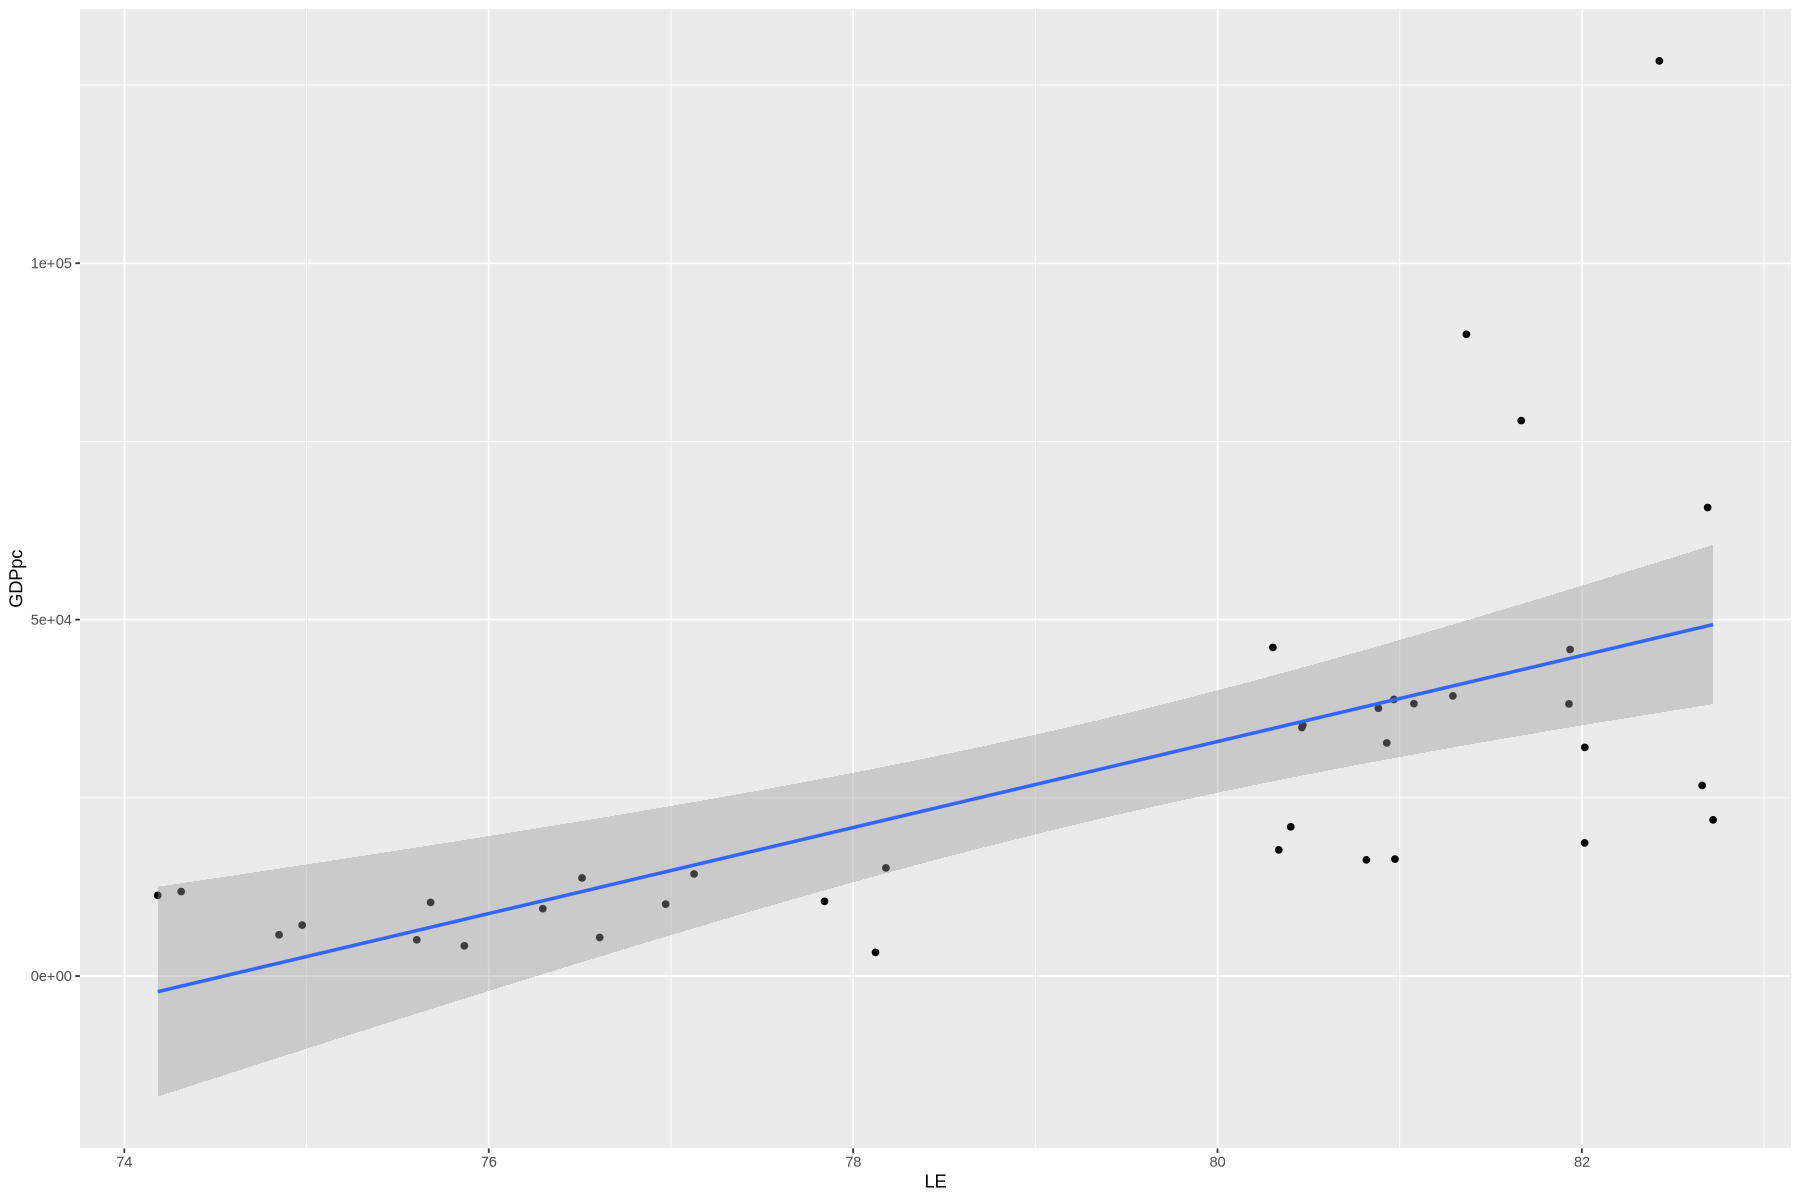

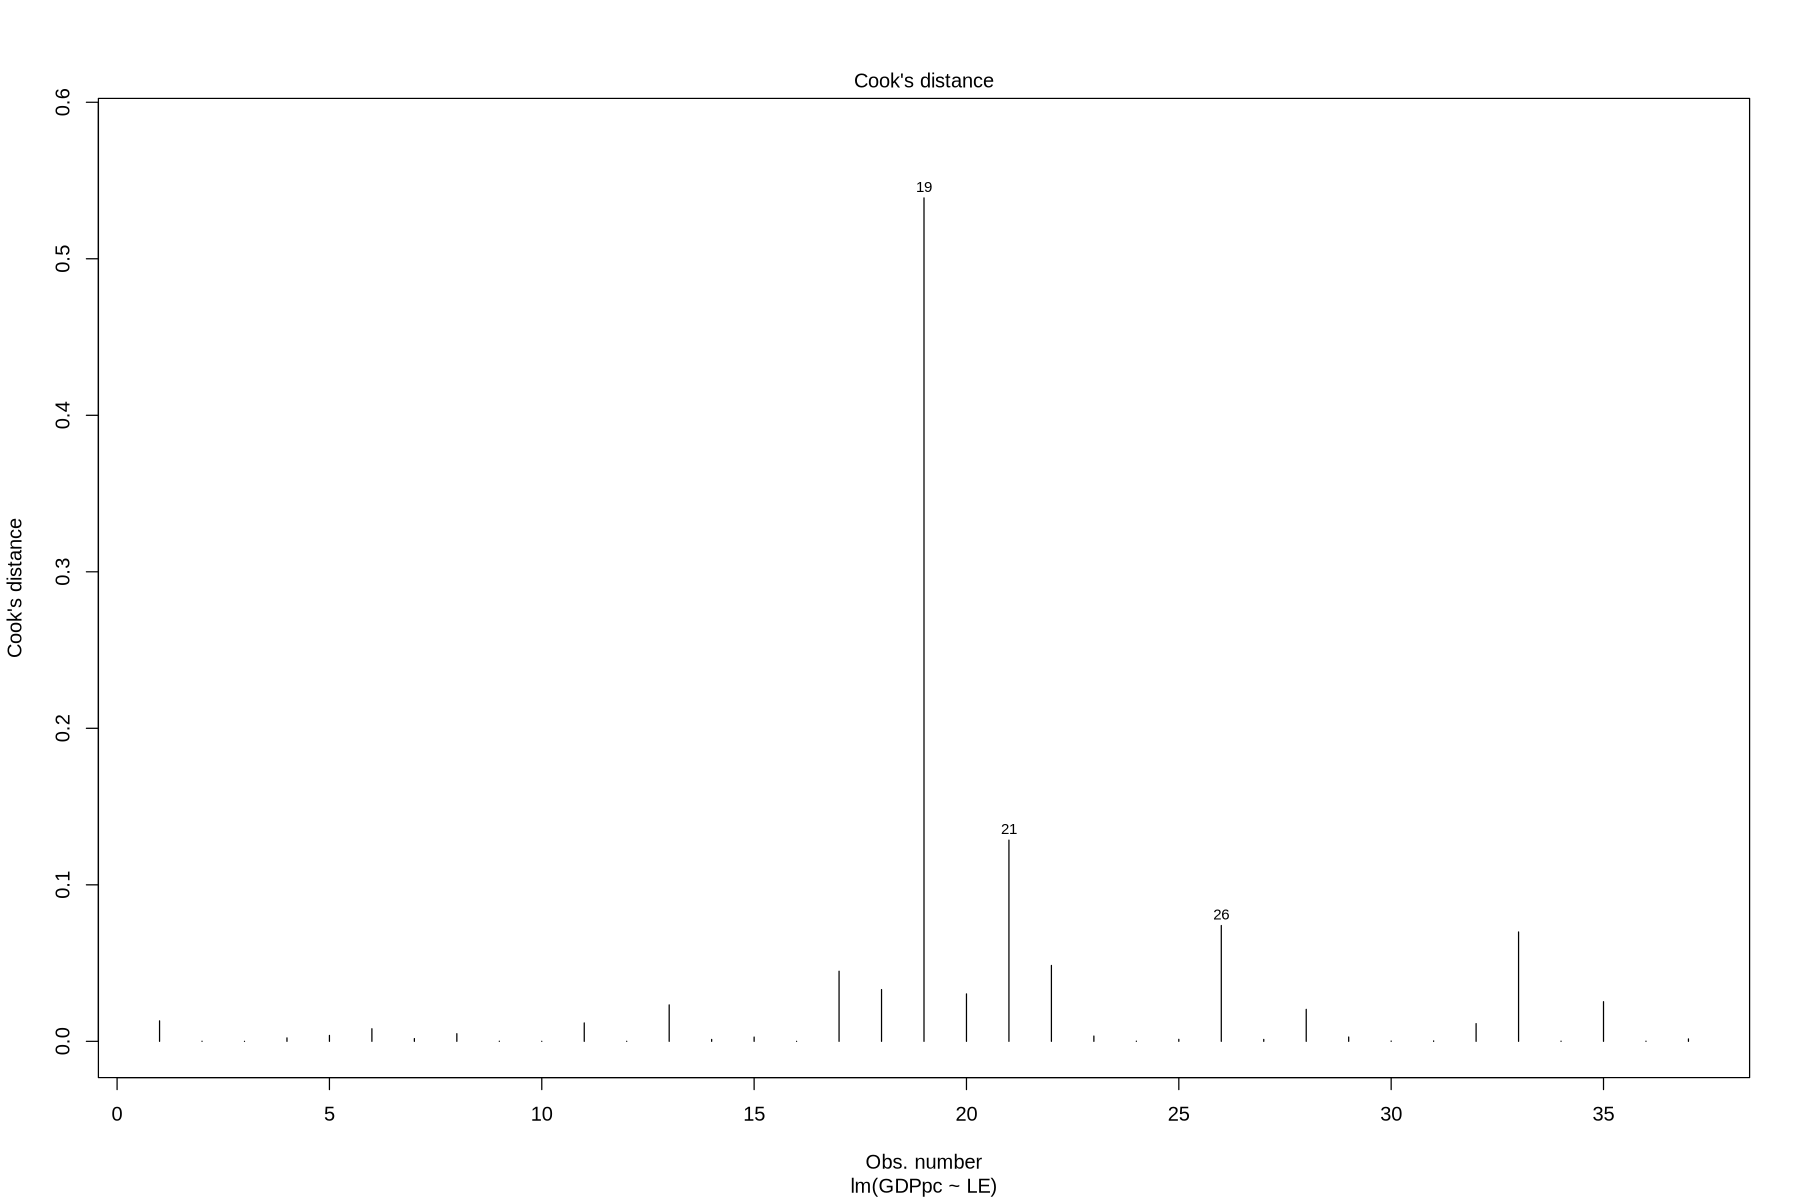

In [56]:
options(repr.plot.width = 15, repr.plot.height=10)

ggplot(fit_LE, aes(x=LE,y=GDPpc)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x)
plot(fit_LE, which=4)

We see, that the Liechtenstein is a strong outlier, we should do something with that - we can try to use some function here to predict better

In [60]:
fit_LE_sq <- lm(GDPpc ~ LE + I(LE^2), data = data)
summary(fit_LE_sq)


Call:
lm(formula = GDPpc ~ LE + I(LE^2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-36004  -9282   -628   2830  74506 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 5547828.1  3884497.9   1.428    0.162
LE          -146717.1    98909.4  -1.483    0.147
I(LE^2)         971.3      628.9   1.544    0.132

Residual standard error: 20420 on 34 degrees of freedom
Multiple R-squared:  0.4377,	Adjusted R-squared:  0.4046 
F-statistic: 13.23 on 2 and 34 DF,  p-value: 5.616e-05


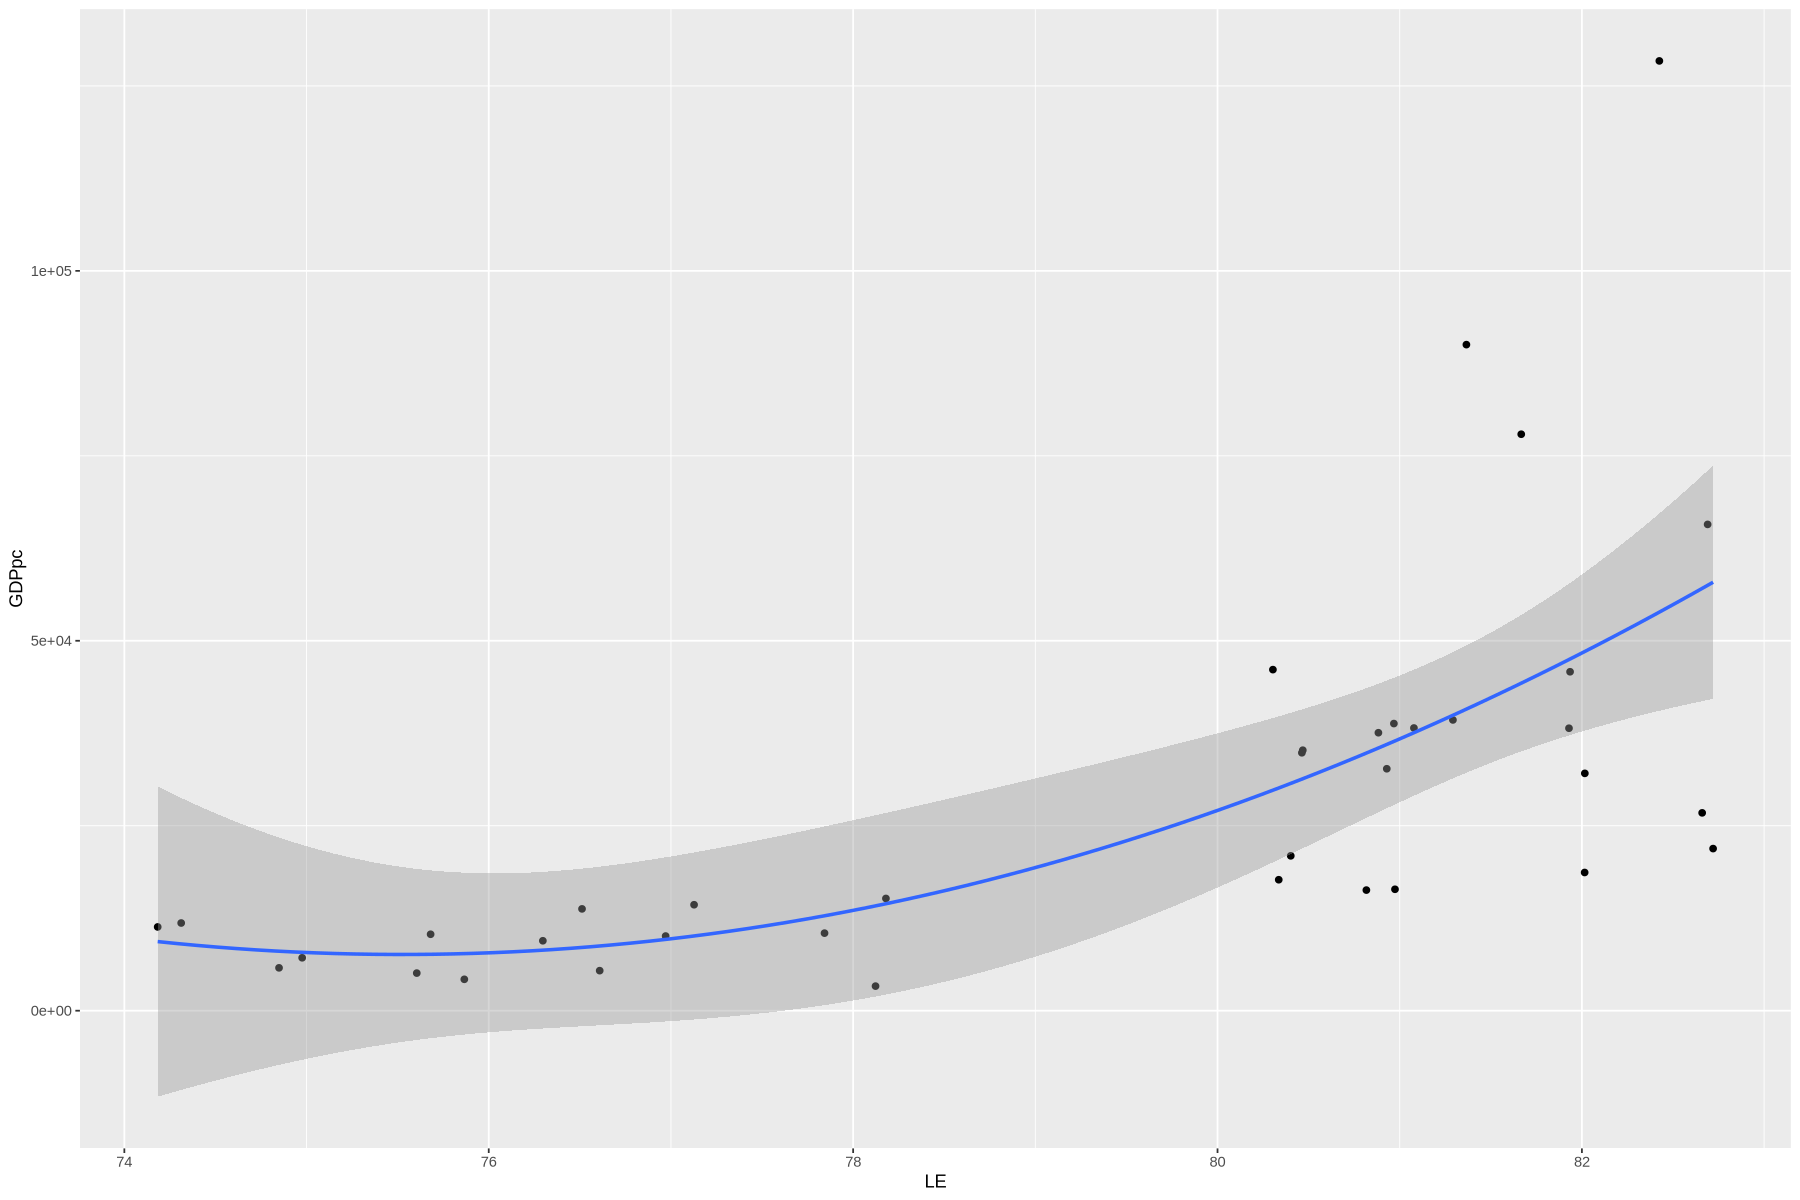

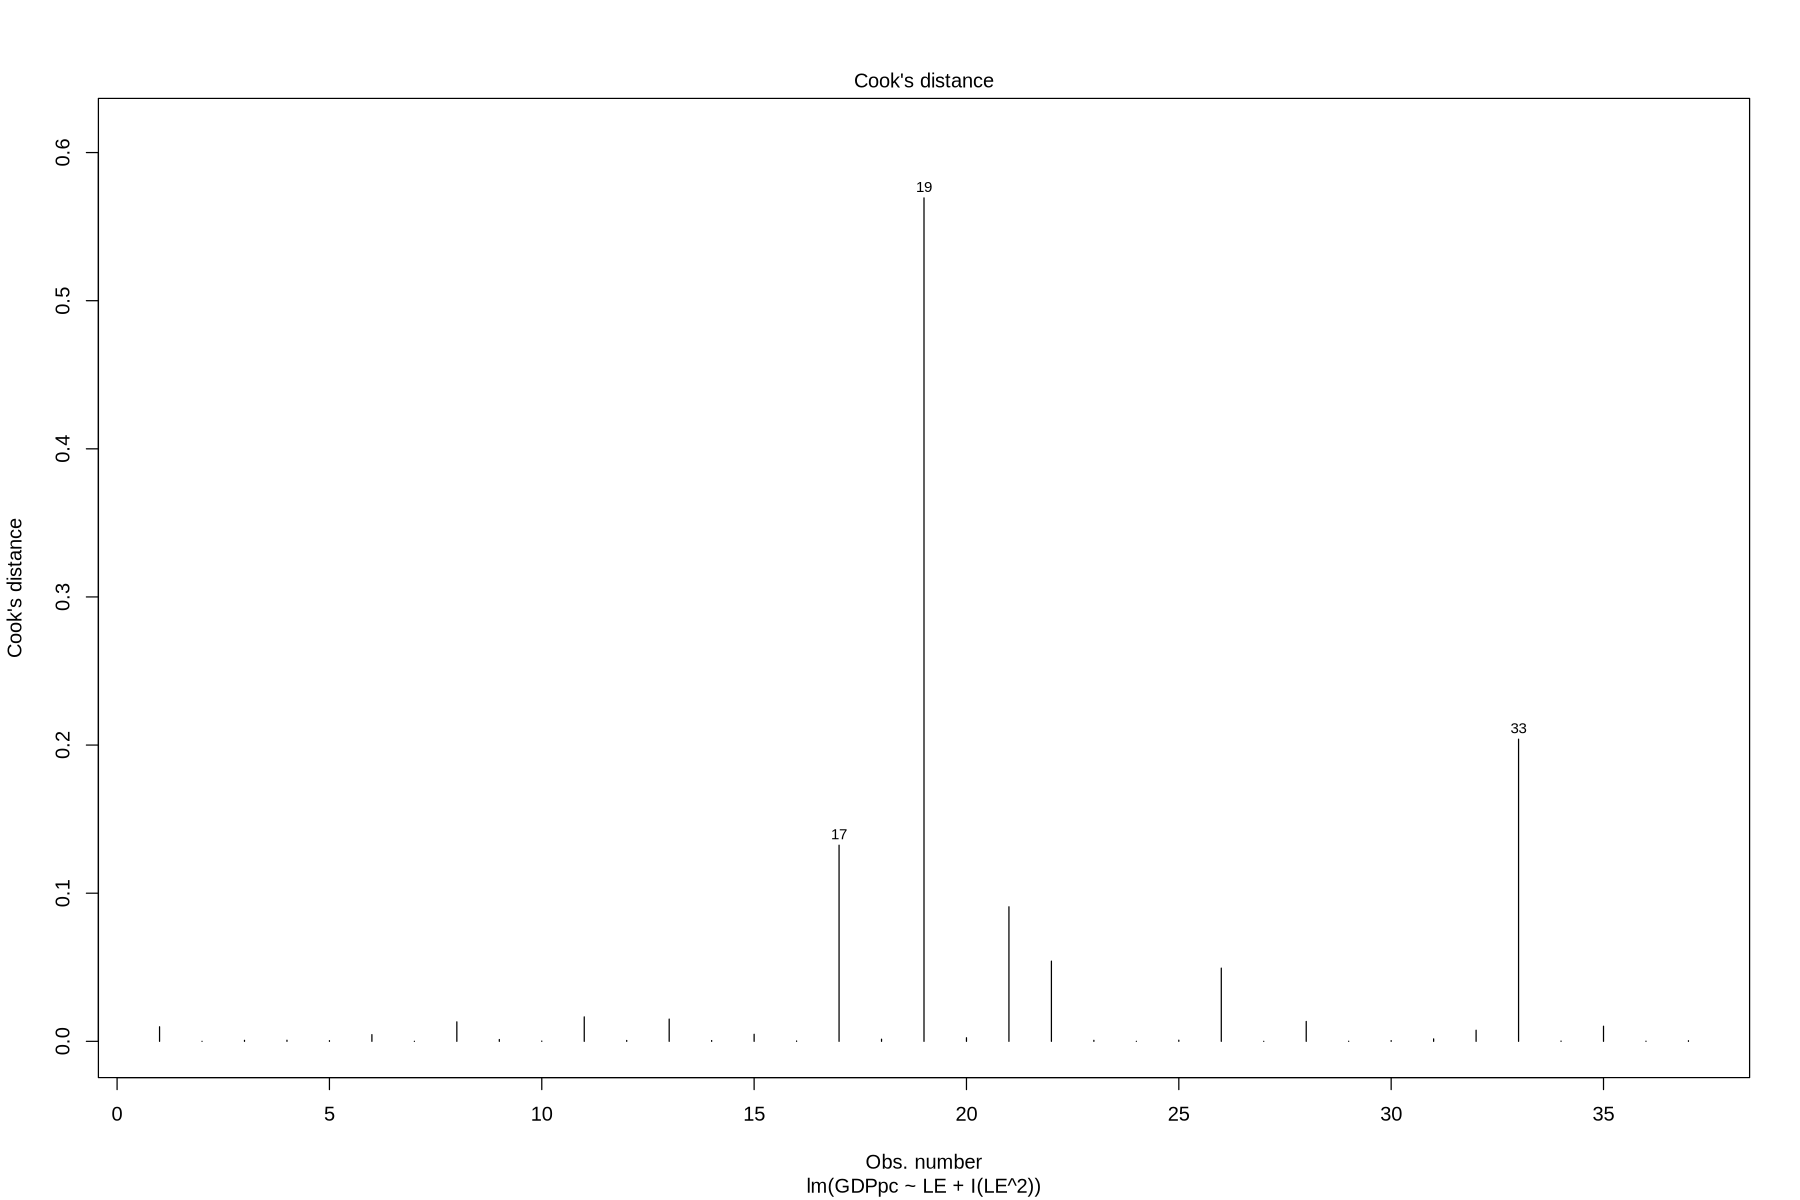

In [67]:
options(repr.plot.width = 15, repr.plot.height=10)

ggplot(fit_LE_sq, aes(x=LE,y=GDPpc)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x + I(x^2))
plot(fit_LE, which=4)

Situation is better now, and we have a better model - with quadratic function the R-squard is higher, let's now consider other regressors

In [72]:
fit_nfiapc <- lm(GDPpc ~ NFIApc, data = data)
summary(fit_nfiapc)


Call:
lm(formula = GDPpc ~ NFIApc, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14782.8  -3188.9    239.6   3493.9  13192.3 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.890e+04  1.096e+03   26.38   <2e-16 ***
NFIApc      -2.008e+00  8.701e-02  -23.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6664 on 35 degrees of freedom
Multiple R-squared:  0.9384,	Adjusted R-squared:  0.9366 
F-statistic: 532.9 on 1 and 35 DF,  p-value: < 2.2e-16


In [73]:
fit_nfiapc_sq <- lm(GDPpc ~ NFIApc + I(NFIApc^2), data = data)
summary(fit_nfiapc_sq)


Call:
lm(formula = GDPpc ~ NFIApc + I(NFIApc^2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-14426  -1848    -72   3514  12810 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.058e+04  1.286e+03   23.78  < 2e-16 ***
NFIApc      -2.333e+00  1.677e-01  -13.91 1.35e-15 ***
I(NFIApc^2) -1.028e-05  4.630e-06   -2.22   0.0332 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6319 on 34 degrees of freedom
Multiple R-squared:  0.9462,	Adjusted R-squared:  0.943 
F-statistic: 298.8 on 2 and 34 DF,  p-value: < 2.2e-16


Using function our model performs a little bit better. Let's inspect the cooks distance

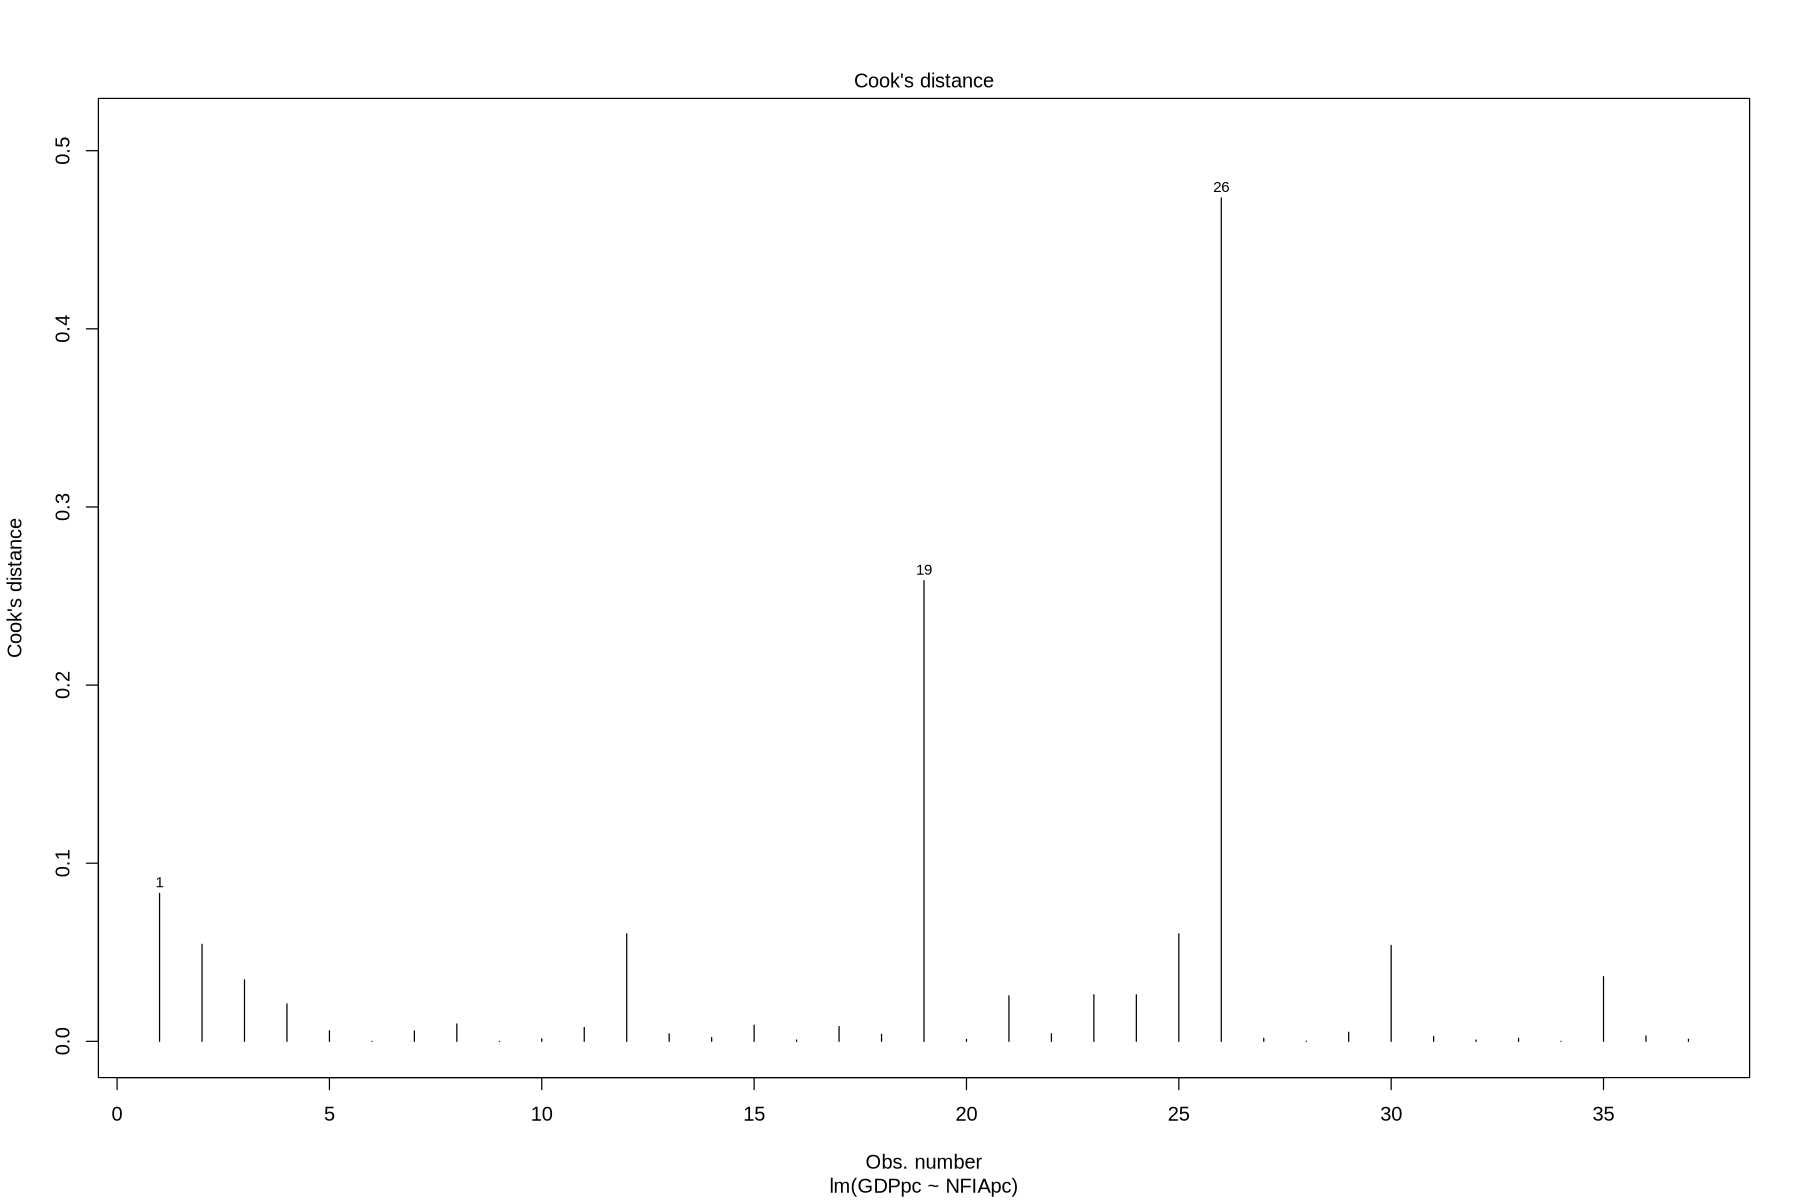

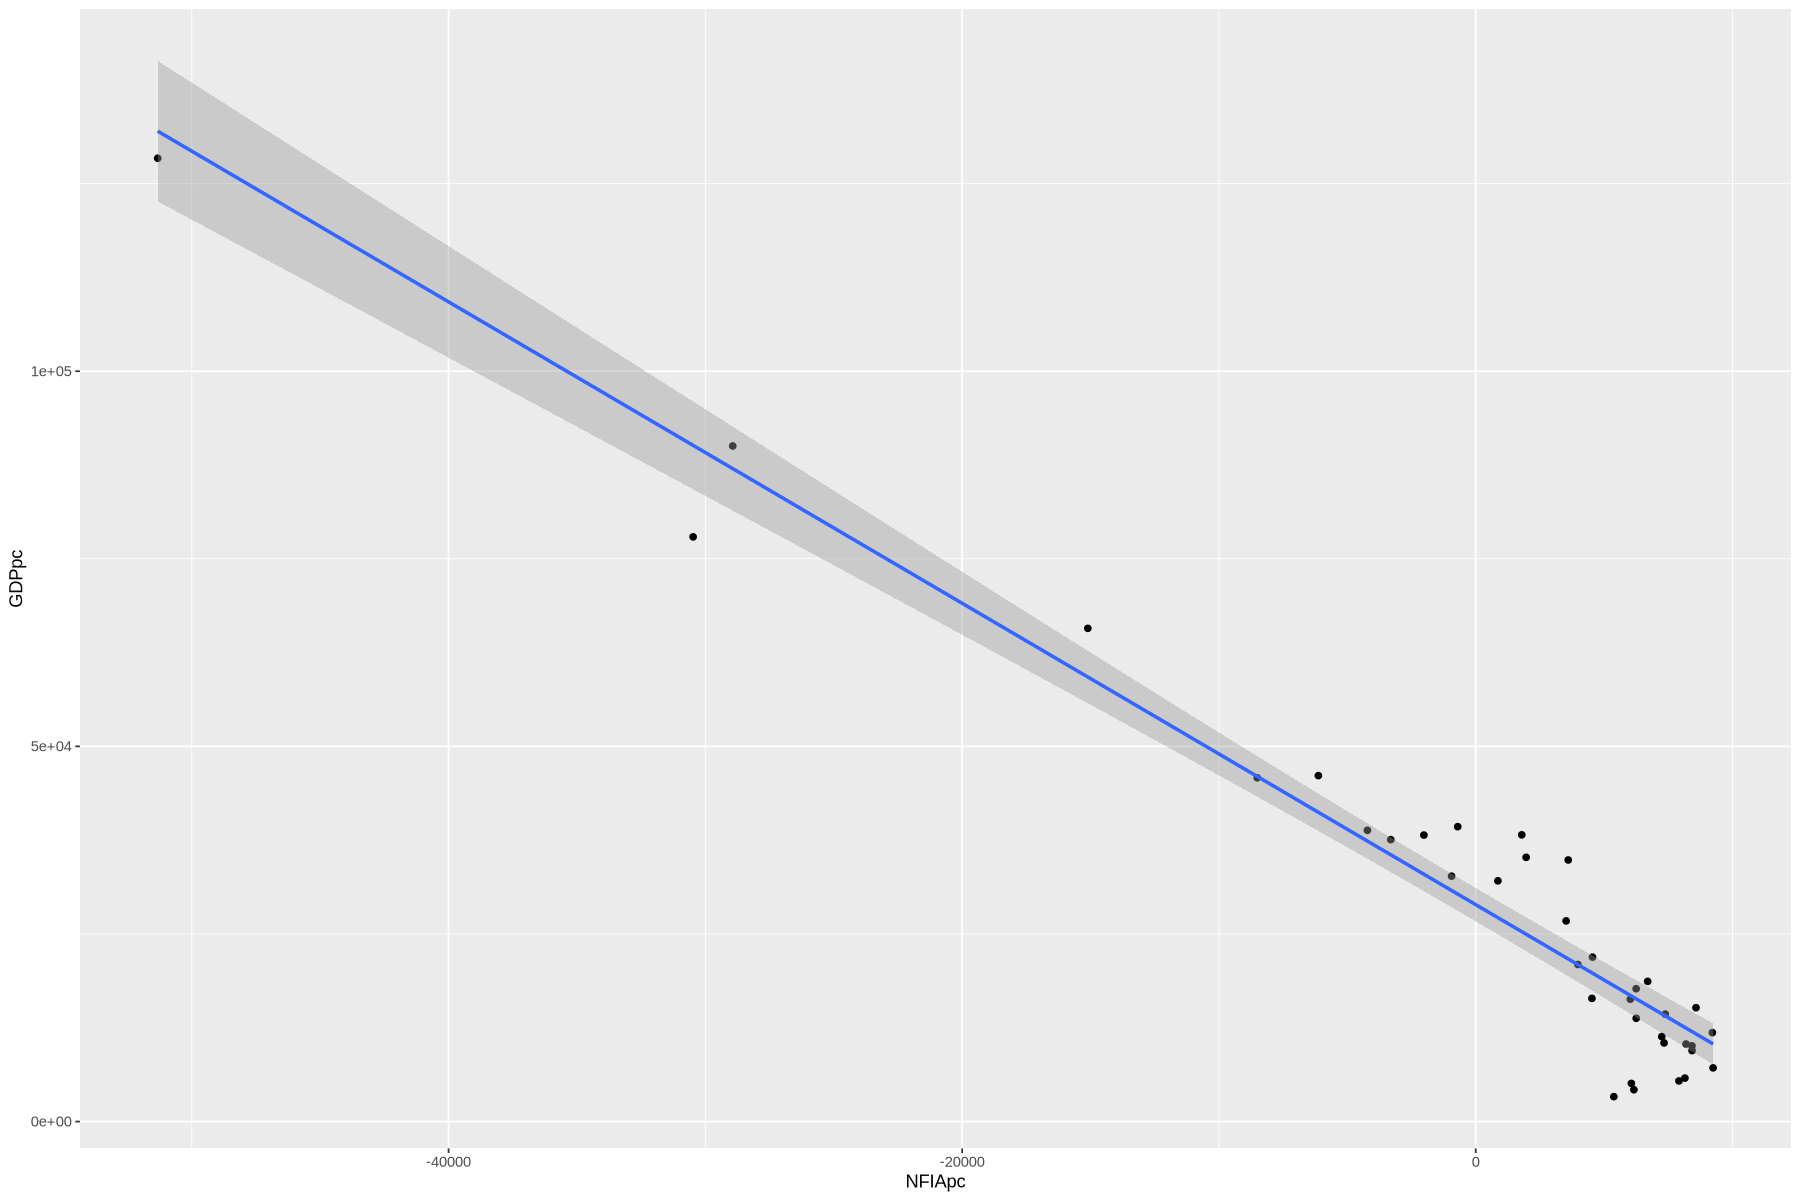

In [77]:
plot(fit_nfiapc, which=4)
ggplot(fit_nfiapc, aes(x=NFIApc,y=GDPpc)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x)

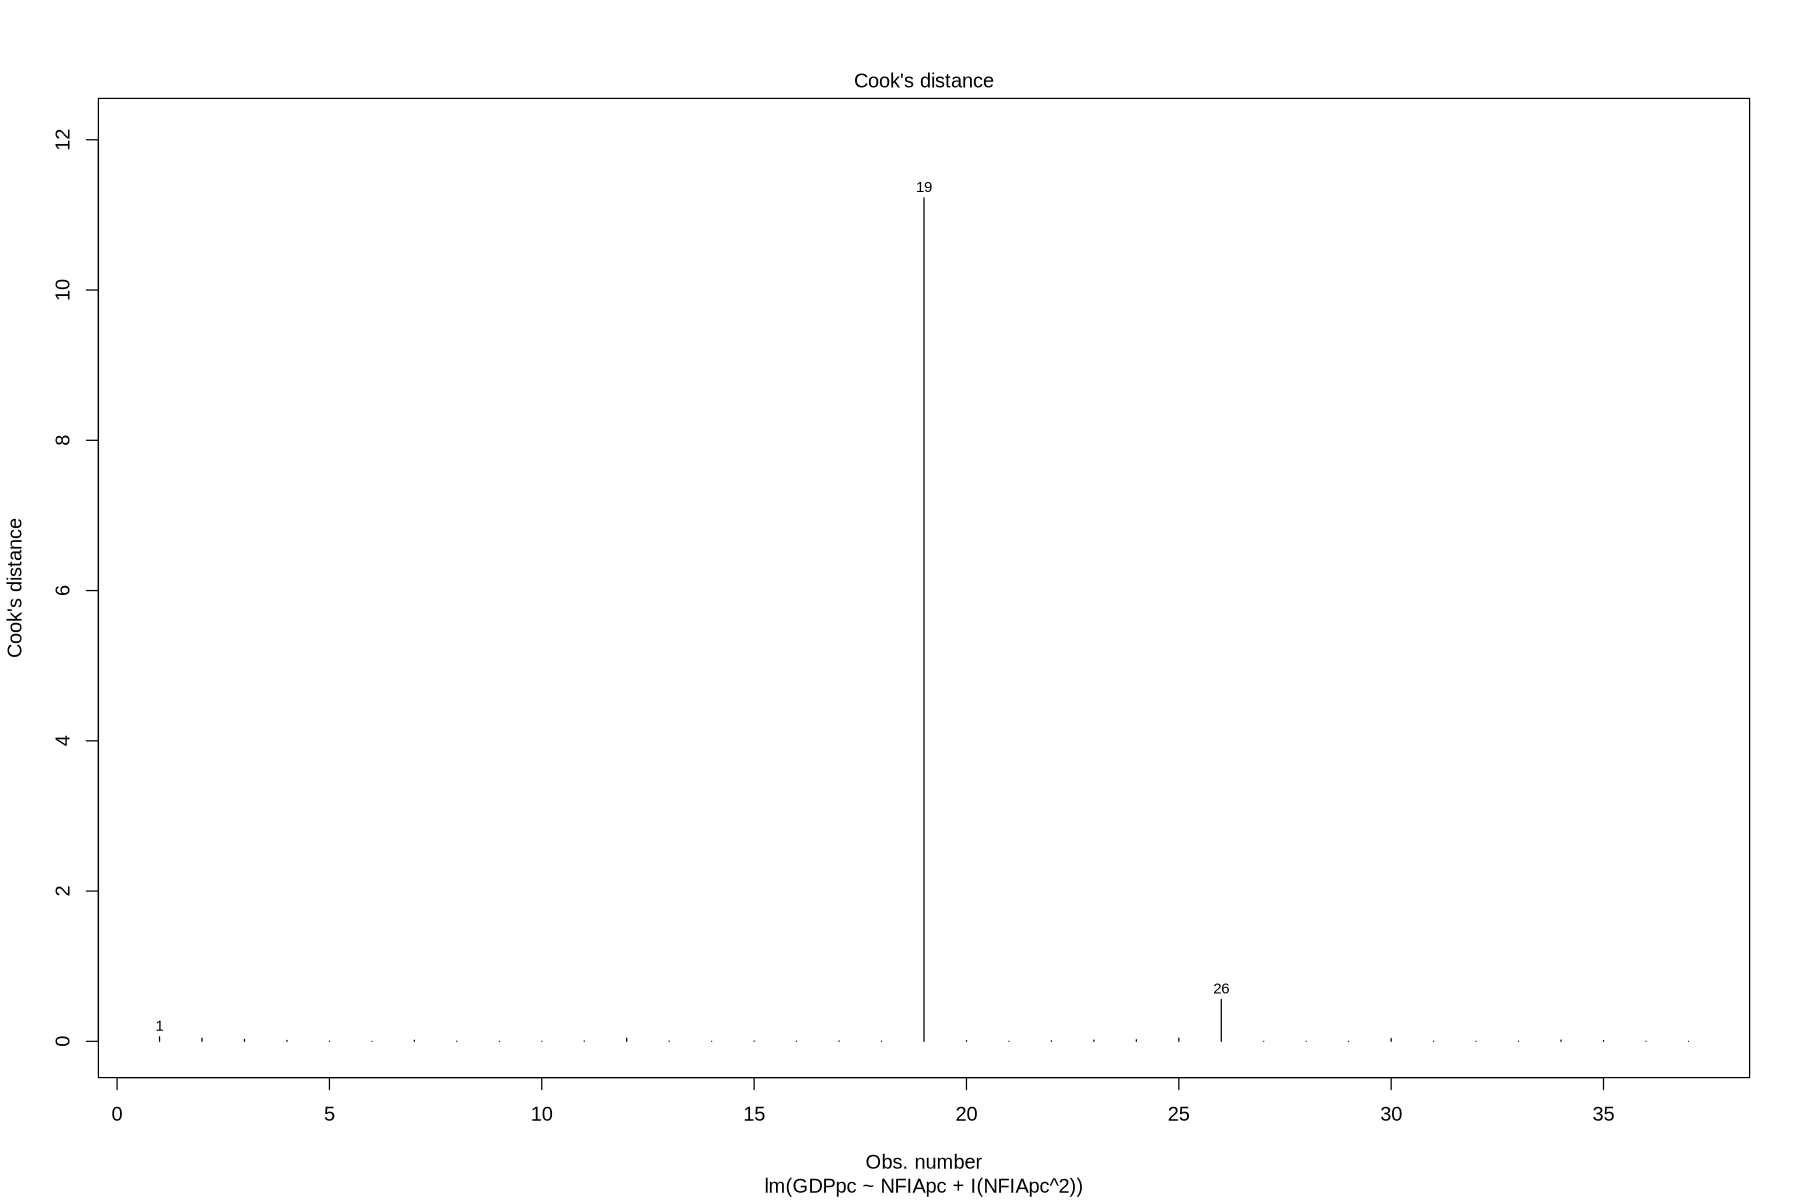

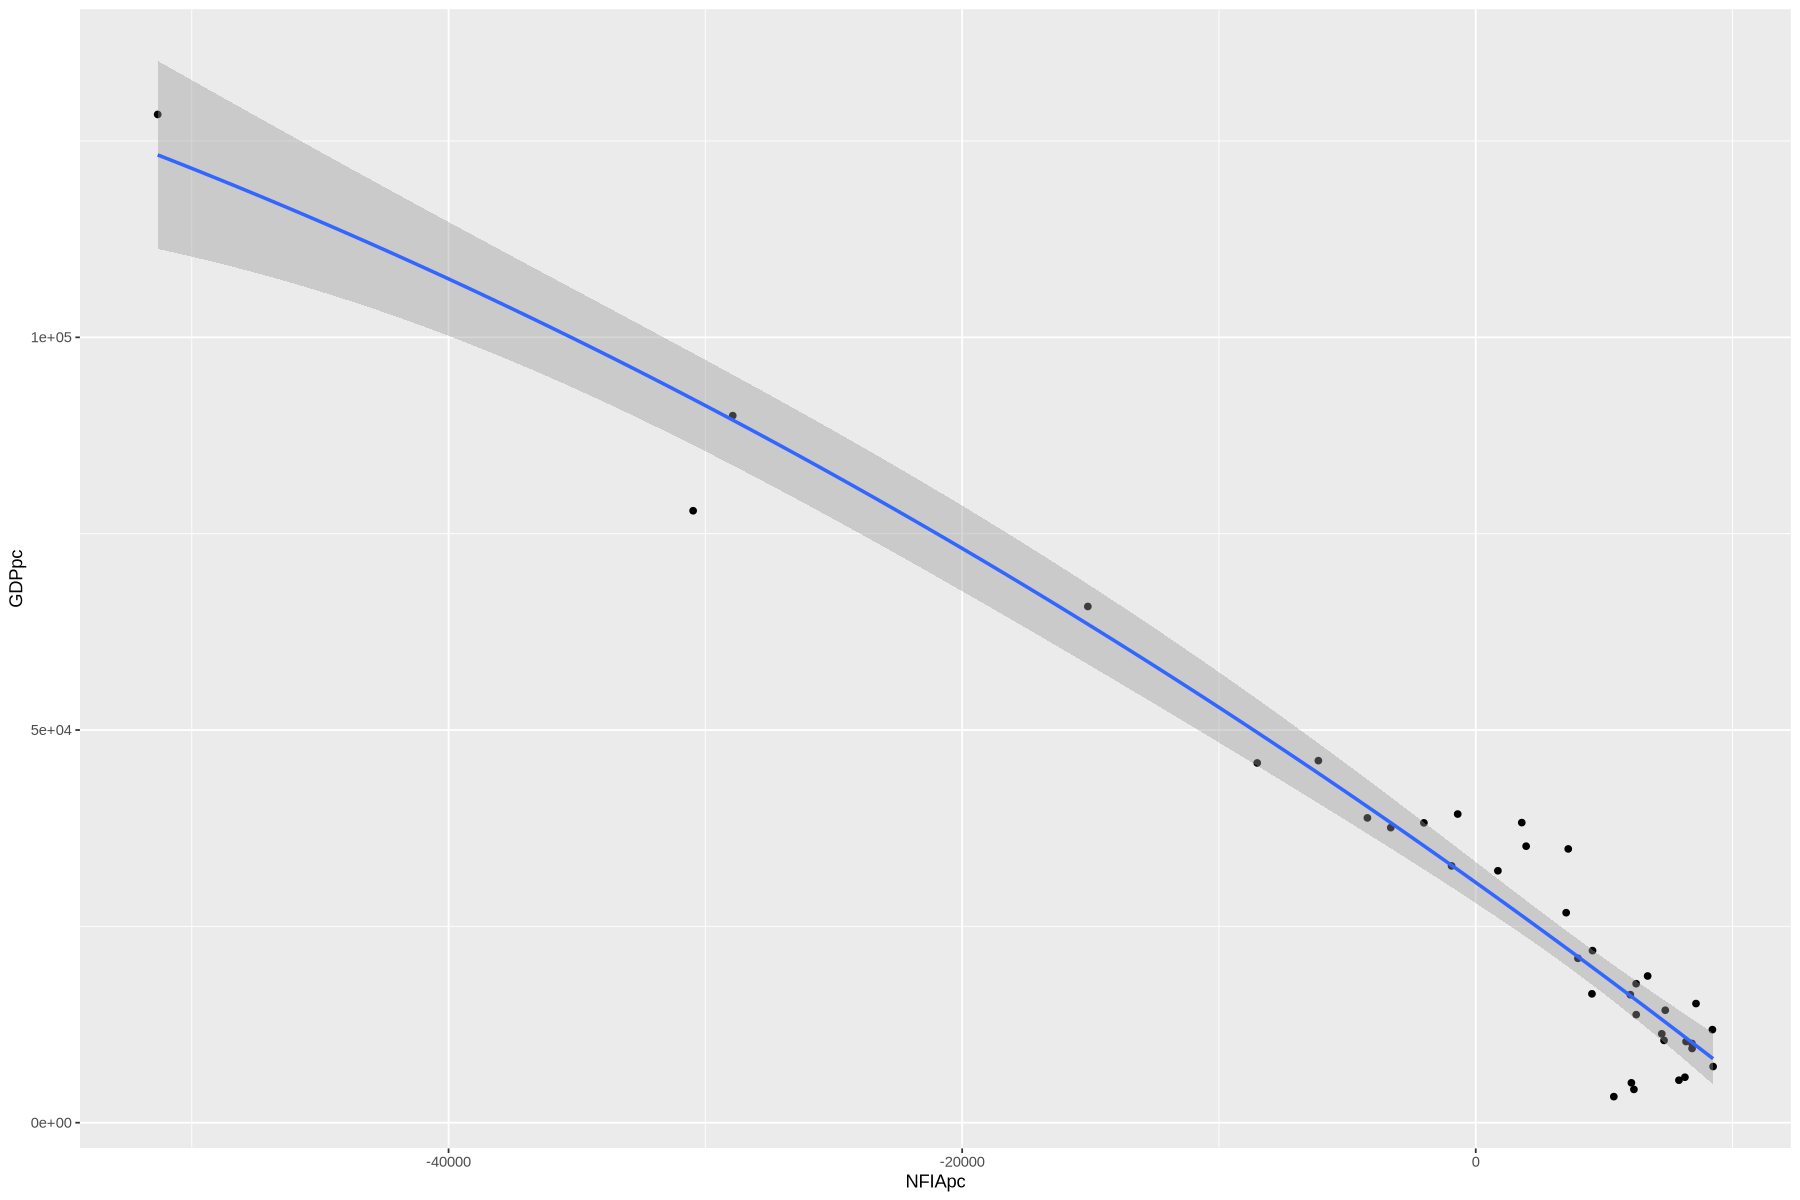

In [80]:
plot(fit_nfiapc_sq, which=4)
ggplot(fit_nfiapc_sq, aes(x=NFIApc,y=GDPpc)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x + I(x^2))

We see here, that still the 19 is still an outlier with quite a big distance. To be sure more sure, let's inspect the 3. regressor

In [81]:
fit_ei <- lm(GDPpc~EI, data=data)
summary(fit_ei)


Call:
lm(formula = GDPpc ~ EI, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-23257 -15052  -4441   4306 103731 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -72815      50016  -1.456   0.1544  
EI            119704      58844   2.034   0.0496 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25390 on 35 degrees of freedom
Multiple R-squared:  0.1057,	Adjusted R-squared:  0.08018 
F-statistic: 4.138 on 1 and 35 DF,  p-value: 0.04956


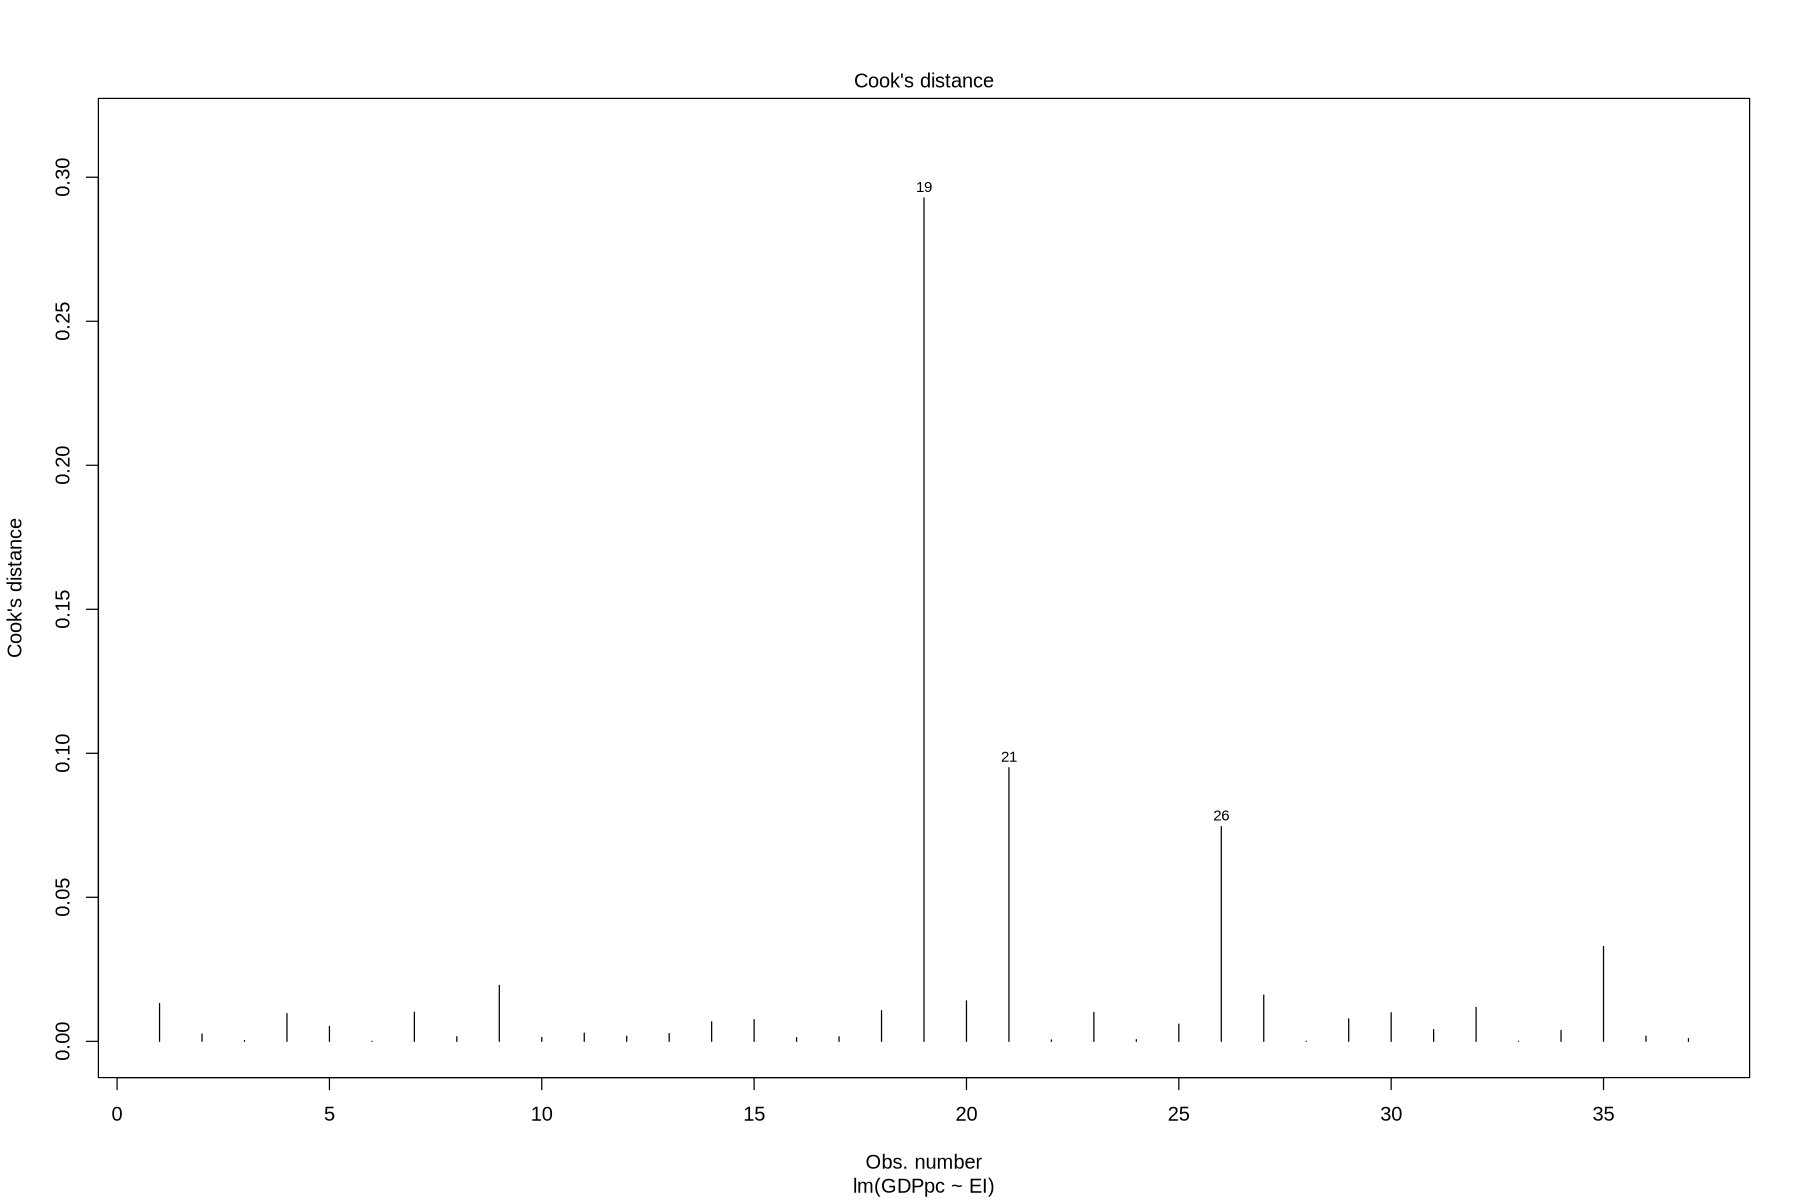

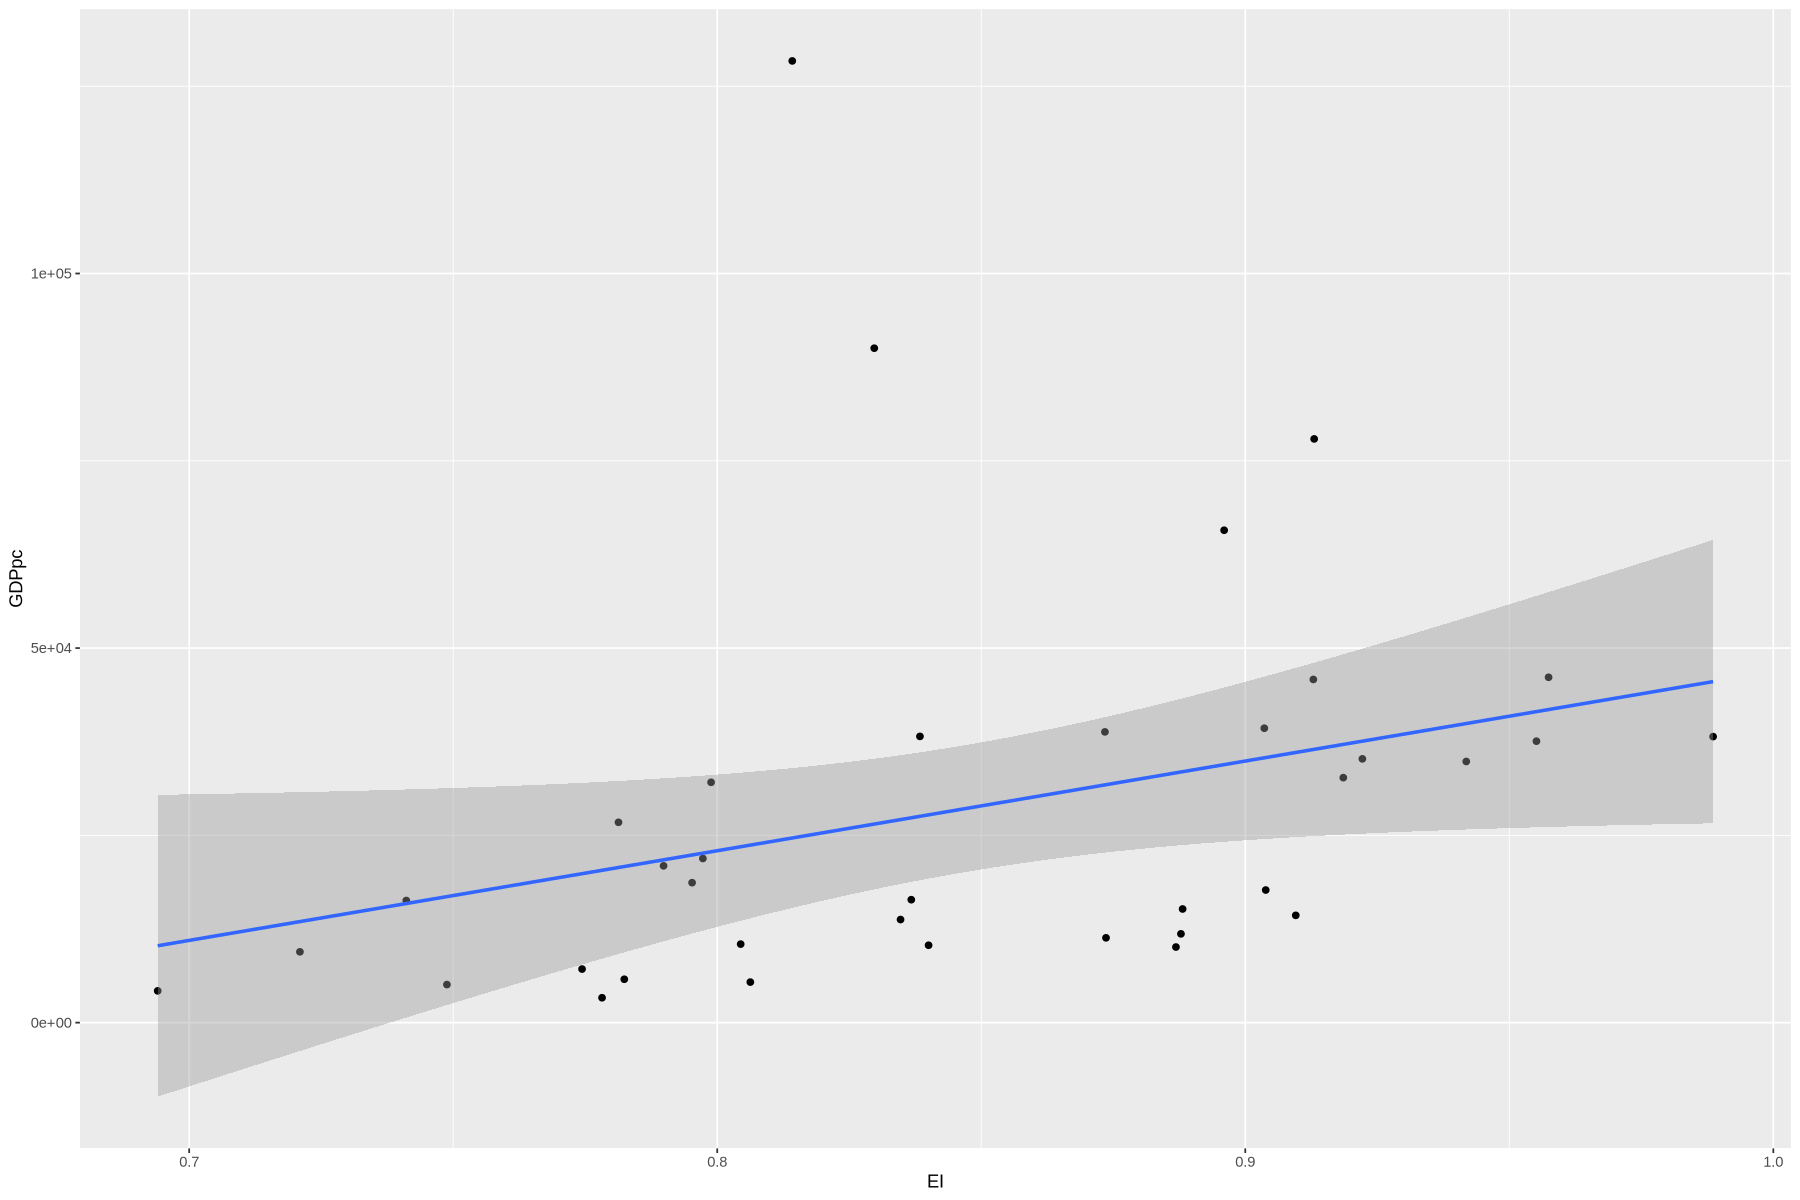

In [105]:
plot(fit_ei, which=4)
ggplot(fit_ei, aes(x=EI,y=GDPpc)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x)

We see, that the 19 data point is really a strong outlier - now we will try to remove it from the dataset, and see what happens with the model. Also we will add regressors with functions.

In [87]:
data_filtered <- data[-19,]

In [90]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(model)
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-10322  -1414      4   2483   5292 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.239e+04  2.214e+04  -3.270 0.002578 ** 
LE            8.415e+02  2.869e+02   2.934 0.006151 ** 
EI            3.814e+04  8.974e+03   4.250 0.000173 ***
NFIApc       -1.747e+00  5.781e-02 -30.215  < 2e-16 ***
BB_entryTRUE  8.231e+03  1.613e+03   5.103 1.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16



Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10264.3  -1625.6    -26.4   2506.1   5352.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.977e+04  2.333e+04  -3.418 0.001782 ** 
LE            9.076e+02  2.944e+02   3.083 0.004278 ** 
EI            4.053e+04  9.286e+03   4.364 0.000131 ***
NFIApc       -1.690e+00  8.076e-02 -20.930  < 2e-16 ***
BB_entryTRUE  8.092e+03  1.619e+03   4.998 2.16e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 31 degrees of freedom
Multiple R-squared:  0.972,	Adjusted R-squared:  0.9684 
F-statistic: 268.9 on 4 and 31 DF,  p-value: < 2.2e-16


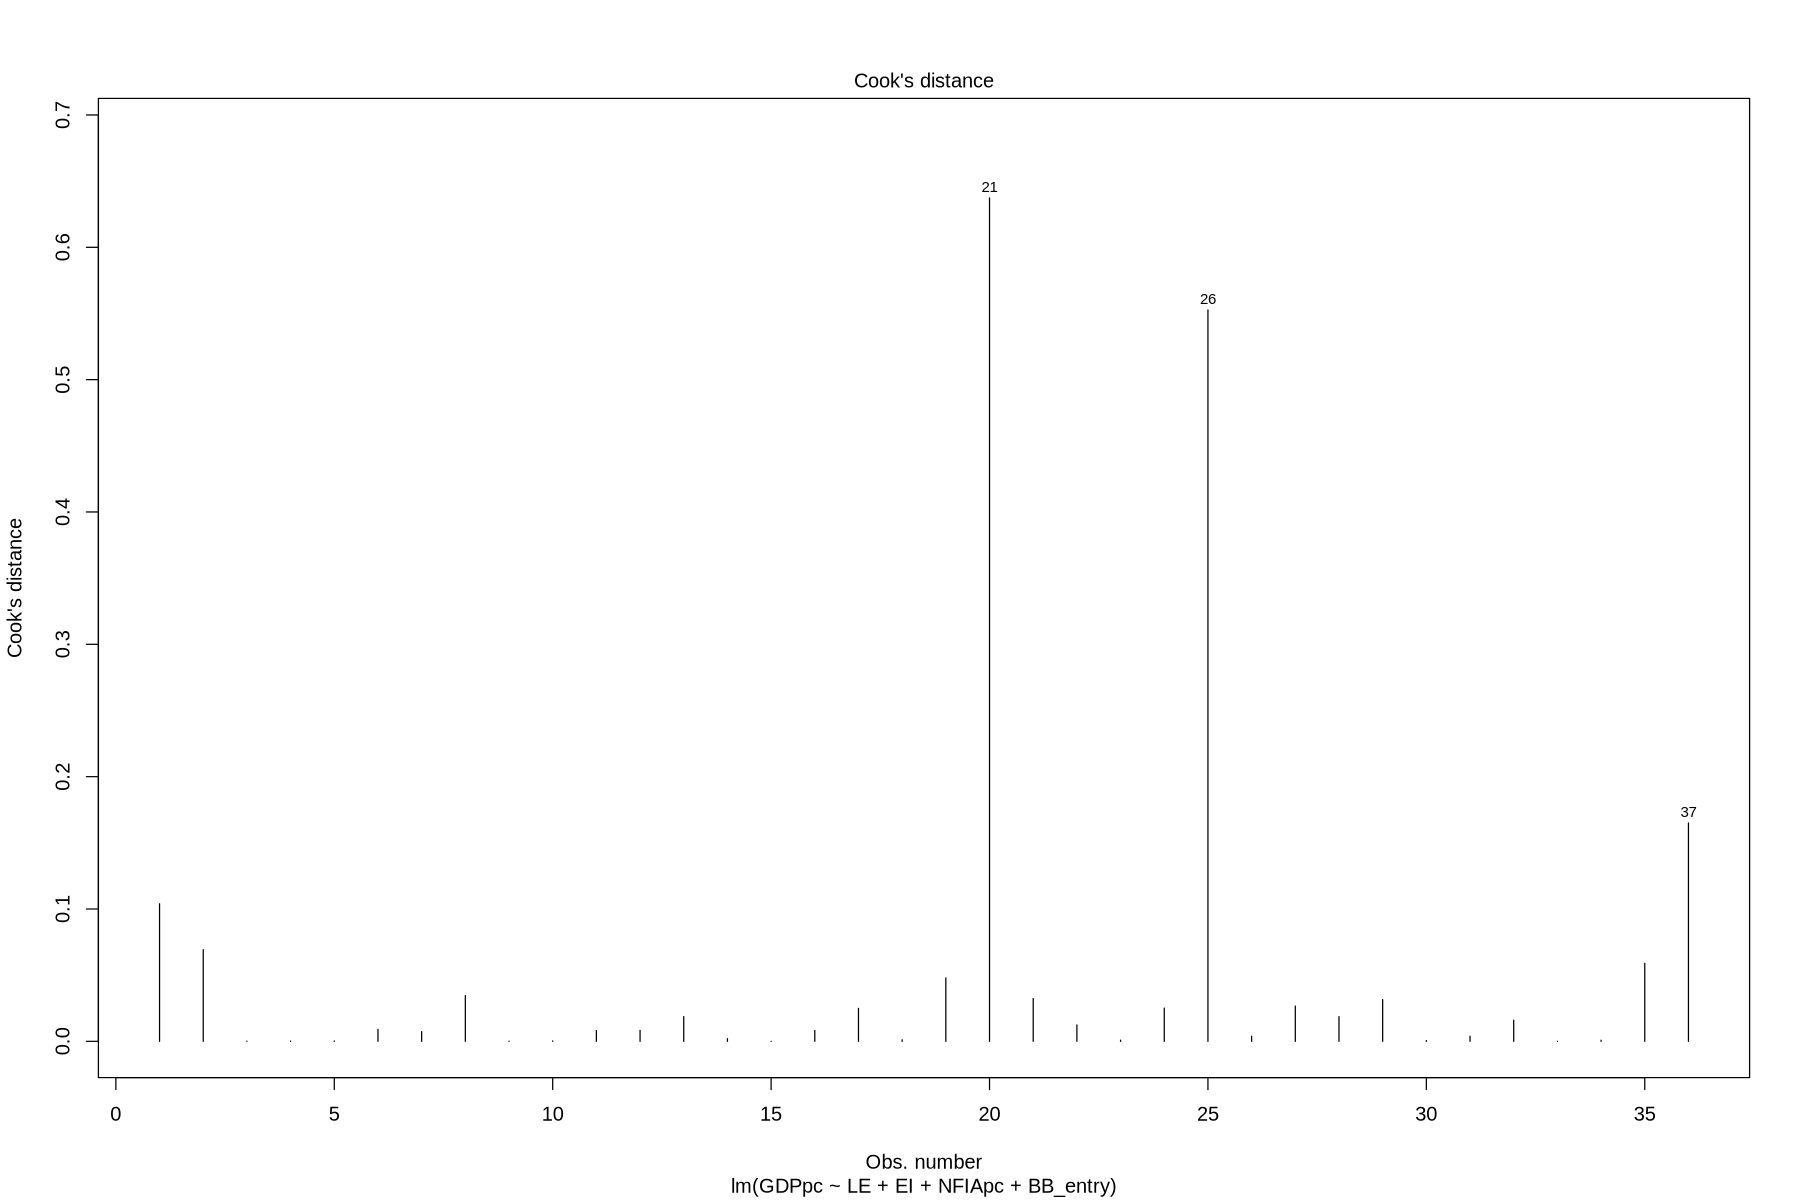

In [91]:
plot(model, which=4)

In [93]:
data[c(26,21),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
26,Norway,77920,81.667,0.9130506,-30476.48,FALSE
21,Luxembourg,90030,81.366,0.8297409,-28933.98,TRUE



Call:
lm(formula = GDPpc ~ LE + I(LE^2) + EI + NFIApc + I(NFIApc^2) + 
    BB_entry, data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-9231.3 -1599.5    35.9  2356.1  5681.5 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.235e+05  7.418e+05   0.841 0.407477    
LE           -1.719e+04  1.896e+04  -0.907 0.372123    
I(LE^2)       1.158e+02  1.209e+02   0.958 0.345915    
EI            4.334e+04  1.029e+04   4.213 0.000223 ***
NFIApc       -1.606e+00  1.931e-01  -8.314 3.64e-09 ***
I(NFIApc^2)   3.152e-06  7.498e-06   0.420 0.677342    
BB_entryTRUE  8.000e+03  1.669e+03   4.794 4.50e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3738 on 29 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9674 
F-statistic: 173.9 on 6 and 29 DF,  p-value: < 2.2e-16


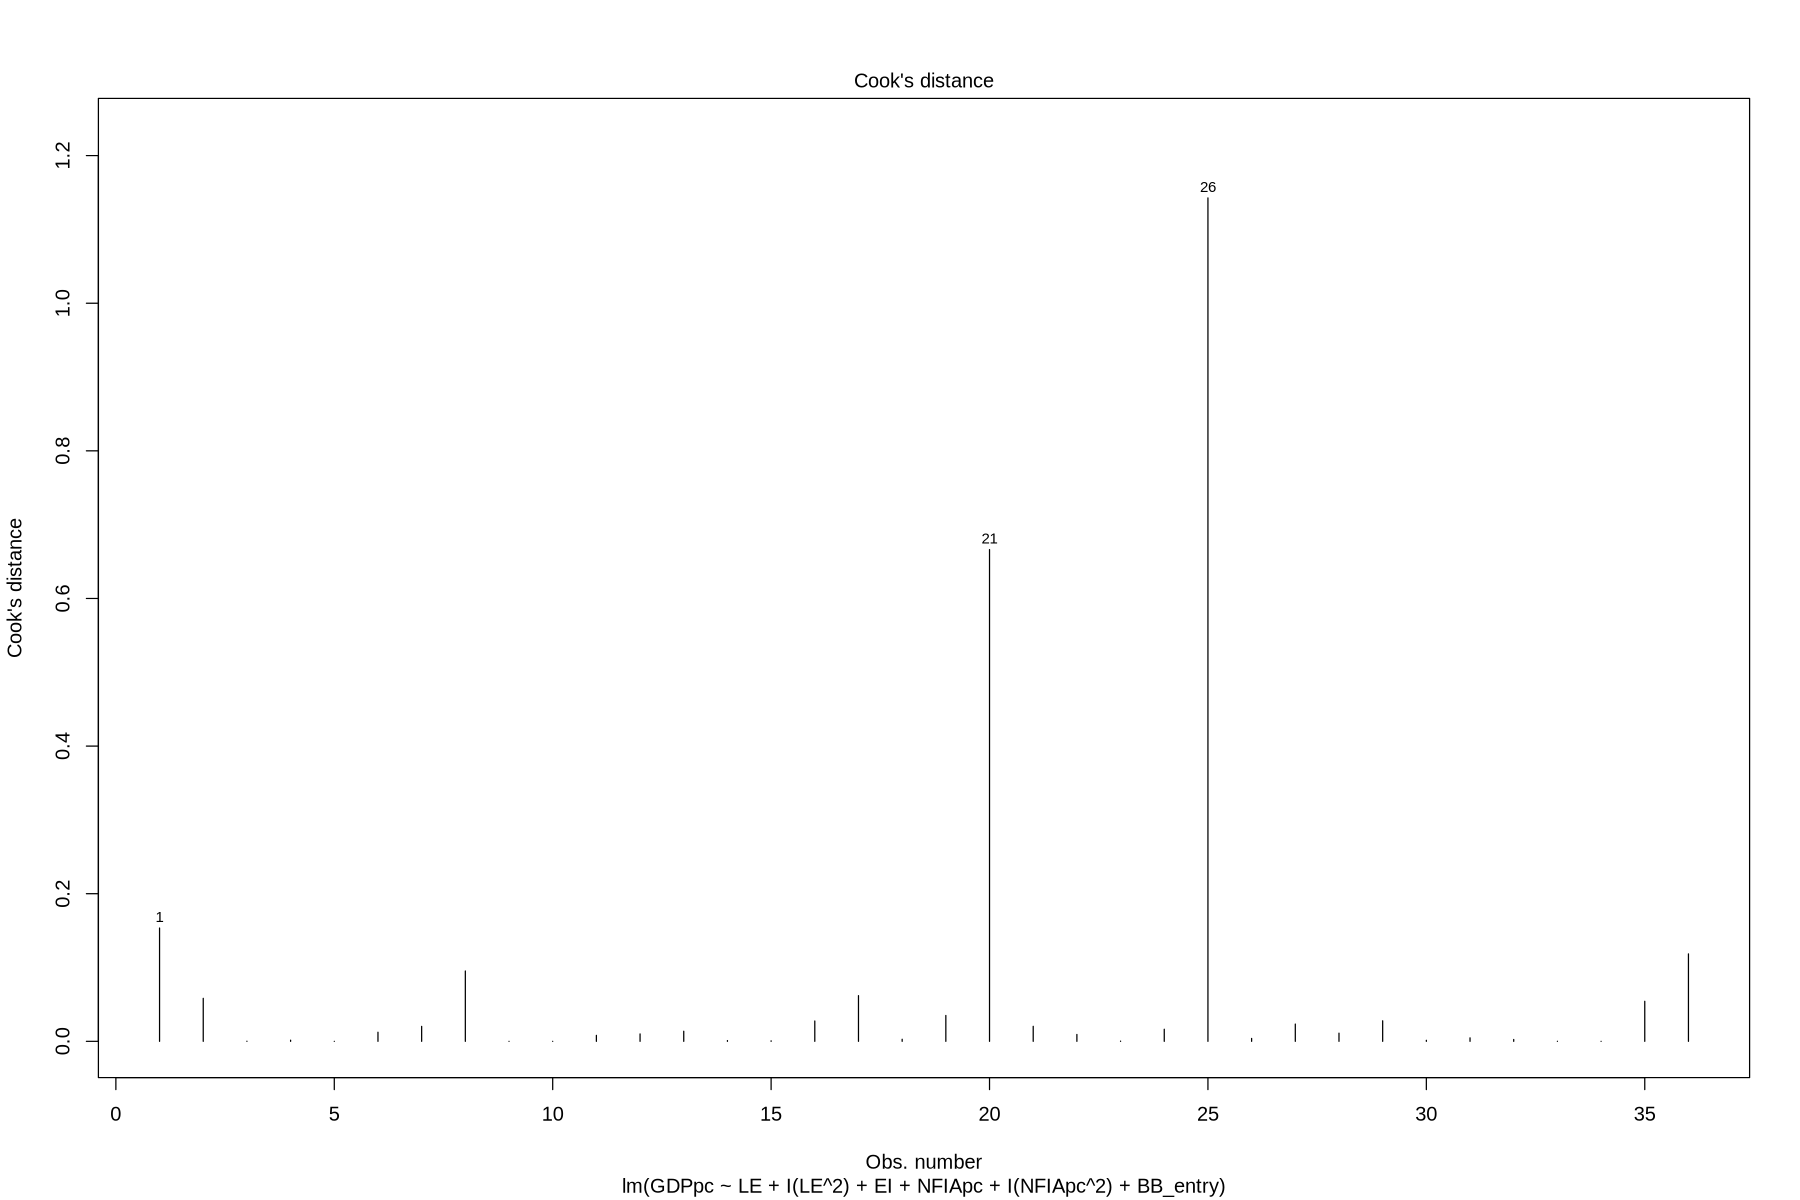

In [94]:
model <- lm(GDPpc ~ LE + I(LE^2) + EI + NFIApc +I (NFIApc^2) + BB_entry, data = data_filtered)
summary(model)
plot(model, which=4)


Call:
lm(formula = GDPpc ~ LE + I(LE^2) + EI + NFIApc + I(NFIApc^2) + 
    BB_entry, data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.0 -1140.4  -174.9  1862.7  6818.2 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.907e+05  6.809e+05   1.014 0.319106    
LE           -1.920e+04  1.741e+04  -1.102 0.279646    
I(LE^2)       1.298e+02  1.110e+02   1.169 0.252413    
EI            4.799e+04  9.610e+03   4.993 2.83e-05 ***
NFIApc       -1.545e+00  1.788e-01  -8.642 2.17e-09 ***
I(NFIApc^2)   1.346e-05  7.982e-06   1.686 0.102973    
BB_entryTRUE  6.783e+03  1.604e+03   4.229 0.000227 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3429 on 28 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9672 
F-statistic: 168.1 on 6 and 28 DF,  p-value: < 2.2e-16


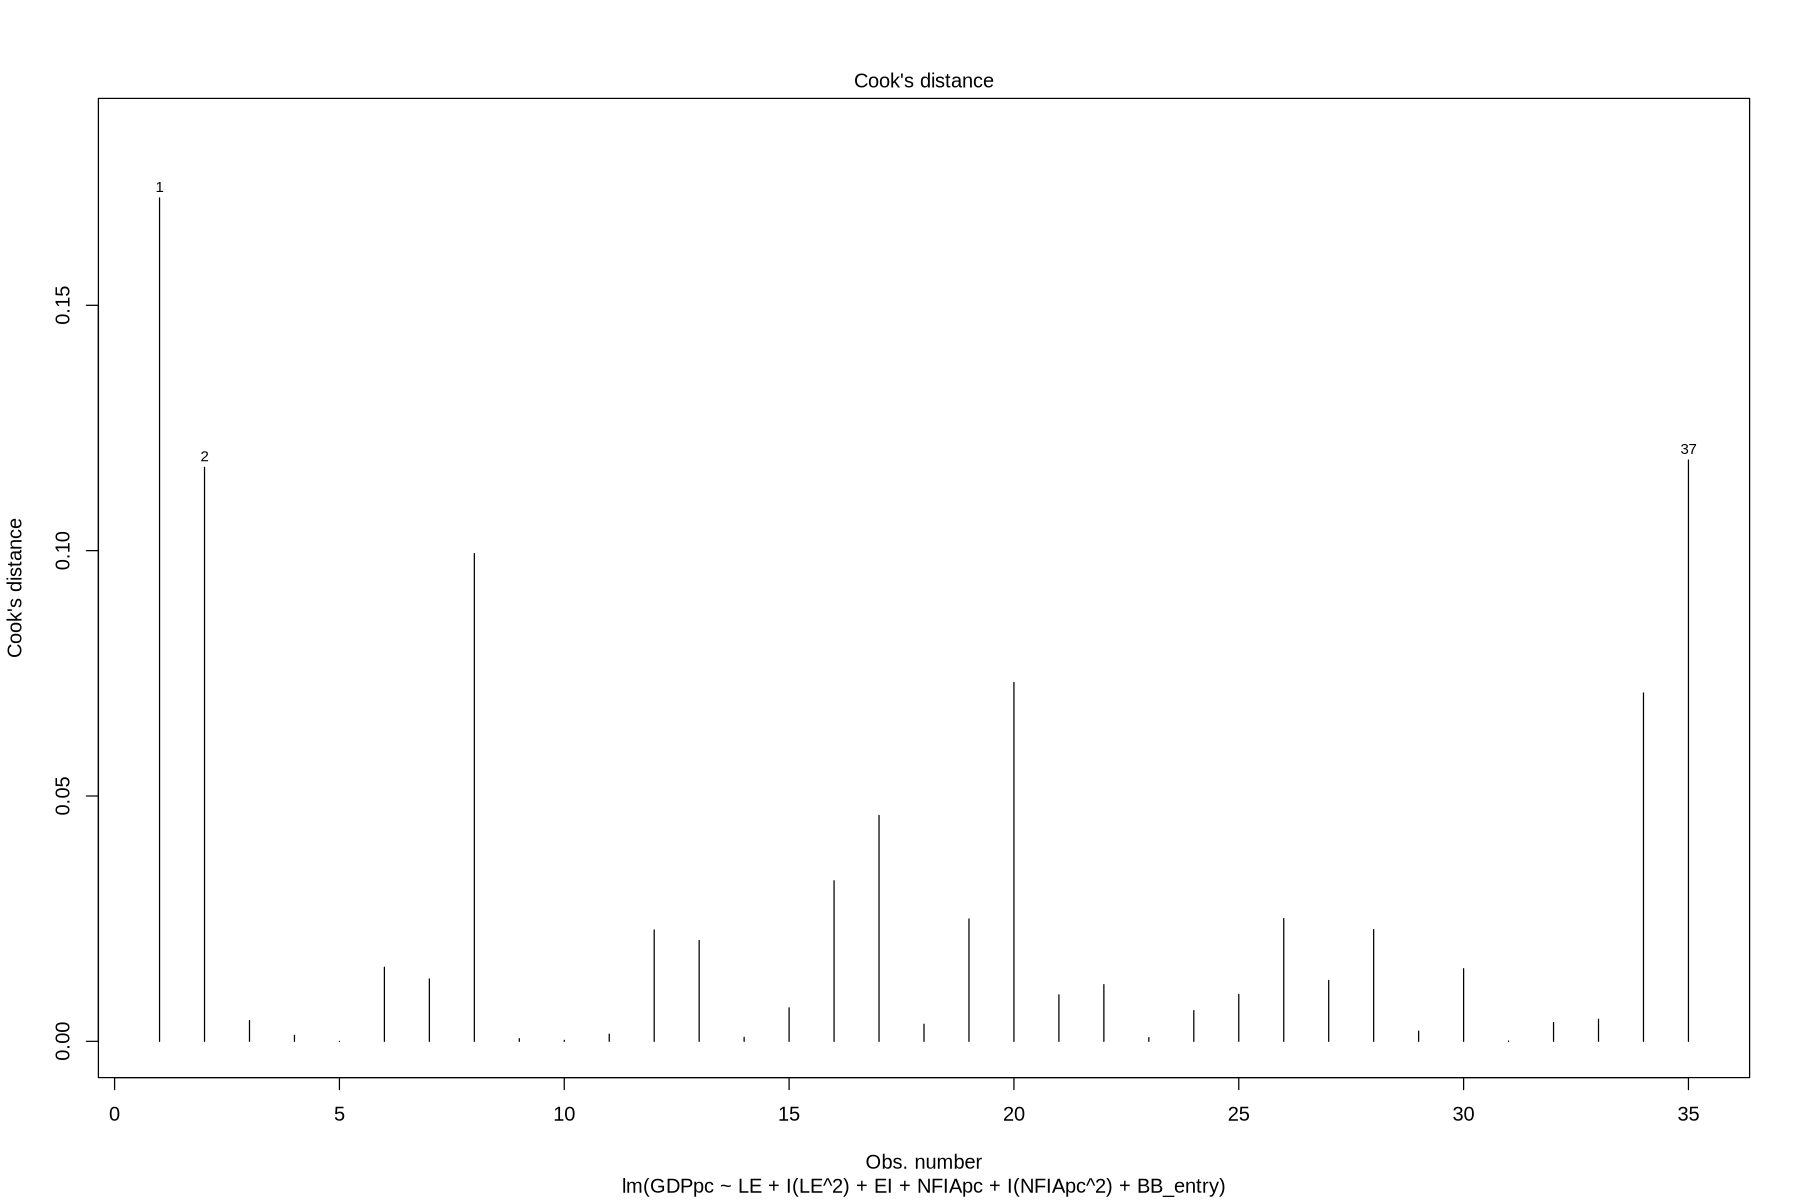

In [100]:
data_filtered2 <- data_filtered[-25,]
model <- lm(GDPpc ~ LE + I(LE^2) + EI + NFIApc +I (NFIApc^2) + BB_entry, data = data_filtered2)
summary(model)
plot(model, which=4)

Now the situation with outliers is much better - distances are quite aligned. We will then remove those two outliers, so our model can generalize better on new data. Finally, lets also consider how the BB feature affects our model.

In [109]:
tapply(data_filtered2$GDPpc, data_filtered2$BB_entry, summary)
# data_filtered2

$`FALSE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3320    9610   14040   17545   20368   46100 

$`TRUE`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26740   32700   35210   43873   39300   90030 


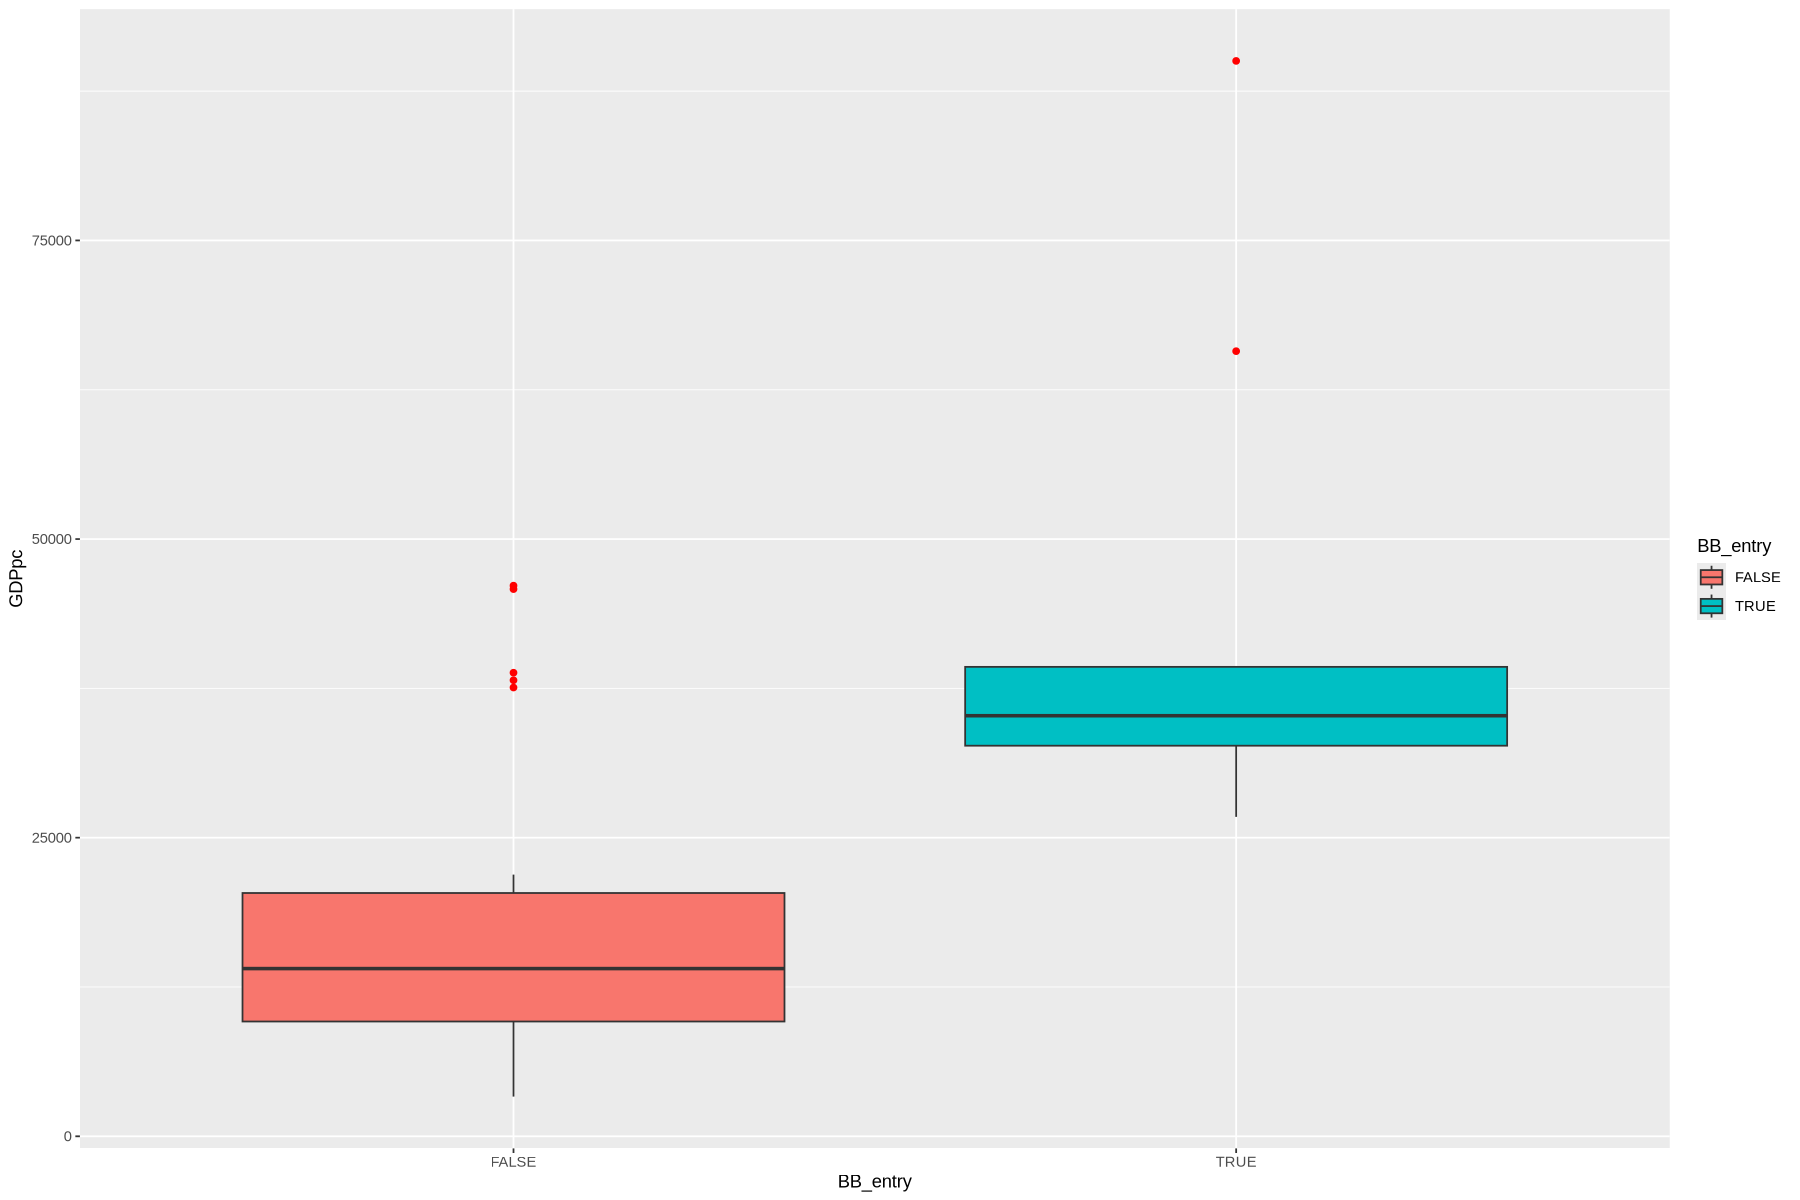

In [113]:
ggplot(data_filtered2, aes(x=BB_entry, y=GDPpc, fill=BB_entry)) +
  geom_boxplot(outlier.color='red')

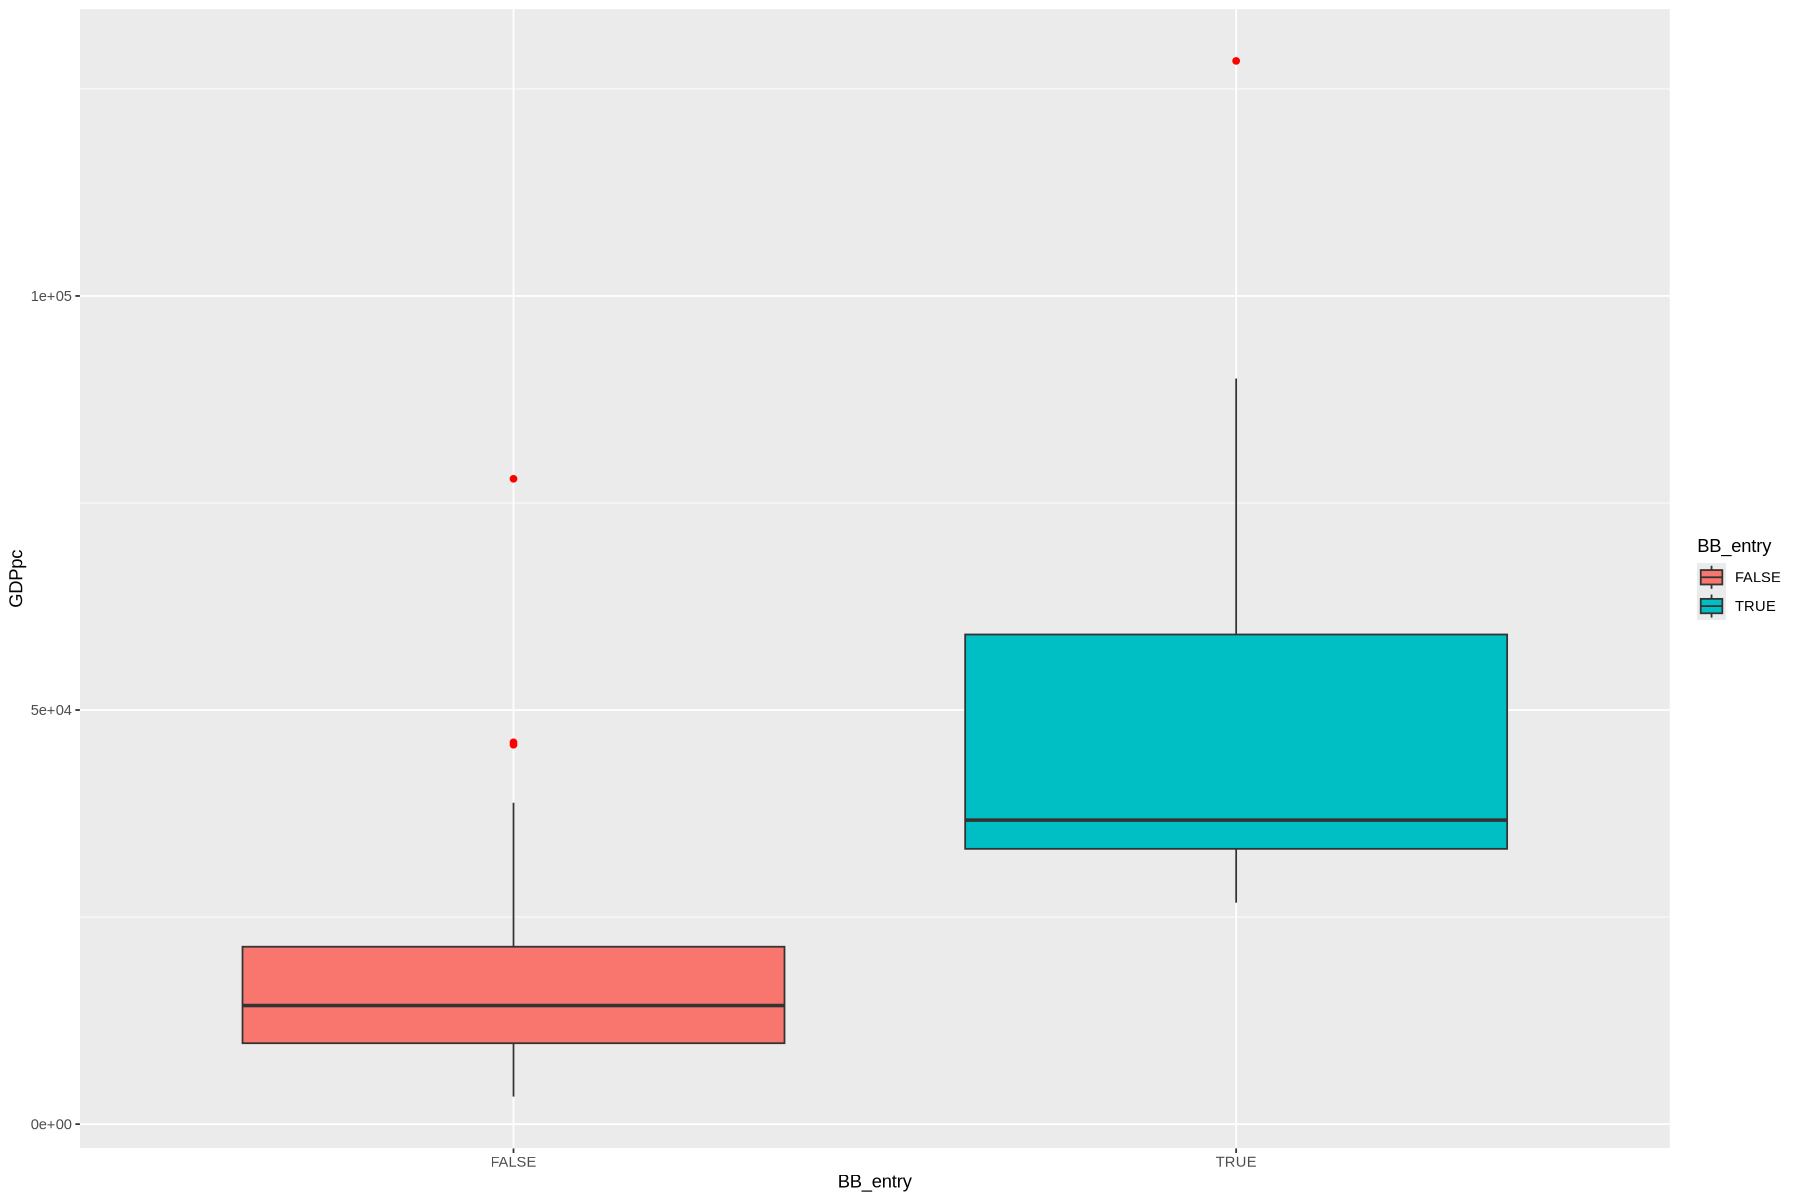

In [114]:
ggplot(data, aes(x=BB_entry, y=GDPpc, fill=BB_entry)) +
  geom_boxplot(outlier.color='red')

So we see, there are some outliers, which may introduce some bias in prediction. But it is not such a problem, because we have another features, which may help to predict those values, and the cook's distance gives much more reliable metric, than this observation.

## Multicollinearity

Now we need to expect multicollinearity in our model. We have 3 numerical and 1 categorical binary feature.

First information we have - we did a correlation marix. From that we can see that there is some linear positive and negative correlations between some of the regressors. But let's see some concrete values:


In [129]:
?par

par {graphics},R Documentation
...,"arguments in tag = value form, a single list of tagged values, or character vectors of parameter names. Supported parameters are described in the ‘Graphical Parameters’ section."
no.readonly,"logical; if TRUE and there are no other arguments, only parameters are returned which can be set by a subsequent par() call on the same device."


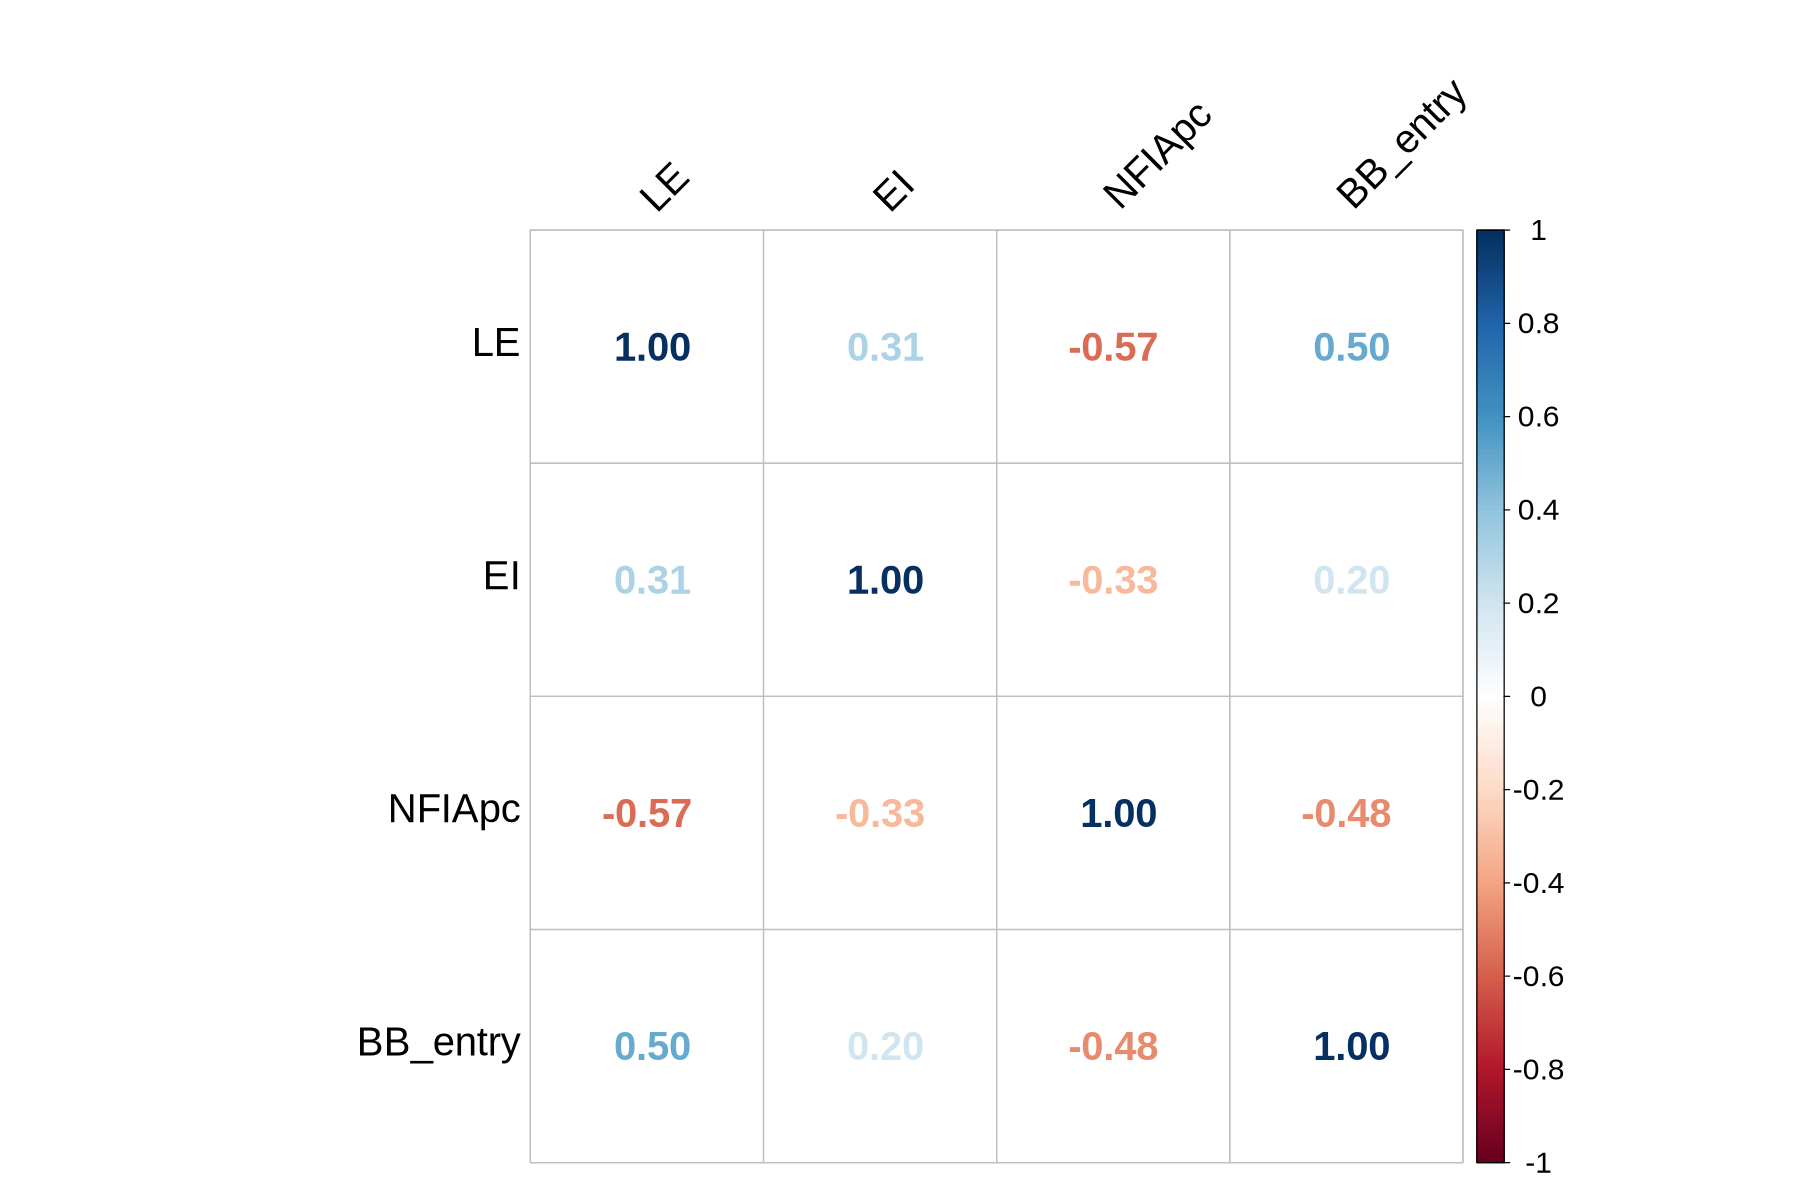

In [139]:
features <- data_filtered2[,-(1:2)]
corrplot(cor(features),
         method='number',
         tl.col='black',
         tl.srt=45,
         tl.cex=2,
         cl.cex=1.5,
         number.cex=2)

So we see that there is some linear positive or strong correlation between some of the features, but nothing too significant, used labels provide some of the new information for prediction.

To test multicollinearity we will use the VIF method.
The VIF method expects linear relationship between predictors and target variable.
But as we saw it before on scatter plot, some of the relationships are no quite linear, but rathier quadratic. So we will test not only original features, but the transformed features too.

In [141]:
model <- lm(GDPpc ~ LE + I(LE^2) + EI + NFIApc +I (NFIApc^2) + BB_entry, data = data_filtered2)
vif_values <- vif(model)
print(vif_values)

         LE     I(LE^2)          EI      NFIApc I(NFIApc^2)    BB_entry 
6693.395522 6722.474994    1.419053    5.665107    3.636925    1.462711 


We see that transformed features and their originals has high VIF value. Let's try VIF only with original and only with transformed features:

In [143]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered2)
vif_values <- vif(model)
print(vif_values)

      LE       EI   NFIApc BB_entry 
1.680608 1.151260 1.656432 1.440983 


There is some moderate correlation, but generally acceptable.

In [145]:
model <- lm(GDPpc ~ I(LE^2) + EI + I(NFIApc^2) + BB_entry, data = data_filtered2)
summary(model)
vif_values <- vif(model)
print(vif_values)


Call:
lm(formula = GDPpc ~ I(LE^2) + EI + I(NFIApc^2) + BB_entry, data = data_filtered2)

Residuals:
     Min       1Q   Median       3Q      Max 
-10948.2  -5091.0   -123.1   3610.3  13198.6 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.761e+05  2.040e+04  -8.632 1.25e-09 ***
I(LE^2)       1.964e+01  3.063e+00   6.410 4.46e-07 ***
EI            8.324e+04  1.614e+04   5.156 1.50e-05 ***
I(NFIApc^2)   7.177e-05  8.214e-06   8.738 9.59e-10 ***
BB_entryTRUE  8.549e+03  2.999e+03   2.851  0.00781 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6490 on 30 degrees of freedom
Multiple R-squared:  0.8963,	Adjusted R-squared:  0.8825 
F-statistic: 64.84 on 4 and 30 DF,  p-value: 2.481e-14


    I(LE^2)          EI I(NFIApc^2)    BB_entry 
   1.428125    1.117638    1.074758    1.427039 


In [146]:
model <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc,2) + BB_entry, data = data_filtered2)
summary(model)
vif_values <- vif(model)
print(vif_values)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered2)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.0 -1140.4  -174.9  1862.7  6818.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -18028       8150  -2.212 0.035282 *  
poly(LE, 2)1        19242       5422   3.549 0.001389 ** 
poly(LE, 2)2         4115       3522   1.169 0.252413    
EI                  47986       9610   4.993 2.83e-05 ***
poly(NFIApc, 2)1   -78280       4979 -15.722 2.00e-15 ***
poly(NFIApc, 2)2     7841       4651   1.686 0.102973    
BB_entryTRUE         6783       1604   4.229 0.000227 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3429 on 28 degrees of freedom
Multiple R-squared:  0.973,	Adjusted R-squared:  0.9672 
F-statistic: 168.1 on 6 and 28 DF,  p-value: < 2.2e-16


                    GVIF Df GVIF^(1/(2*Df))
poly(LE, 2)     2.601322  2        1.269985
EI              1.419053  1        1.191240
poly(NFIApc, 2) 3.087381  2        1.325554
BB_entry        1.462711  1        1.209426


Interesting results.. Let's see if we can use other methods for multicollinearity check.

The condition index can be used to check for multicollinearity between two features - let's create a function that will do that:

https://cran.r-project.org/web/packages/olsrr/vignettes/regression_diagnostics.html

## Model Premises Tests

## Final Model